In [1]:
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.models as models
import torch.nn.functional as F
import random
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
val_filter = lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49}

In [4]:
import torchvision.transforms as transforms

class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands, patch_size, time=12):
        self.bands = bands
        self.patch_size = patch_size
        self.time = time

    def __call__(self, x):
        return x.view(self.time, self.bands, self.patch_size, self.patch_size).permute(1, 0, 2, 3)

def scale_up_planet_channels(x):
    x[:3] *= 5  # 첫 3개 채널을 5배 스케일링
    return x

def base_transform(bands, patch_size, scale_channels=True):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands, patch_size),  # (12*bands, height, width) → (bands, time, height, width)
        transforms.Lambda(scale_up_planet_channels)  # 첫 3개 채널을 5배 확대
    ])


In [5]:
class ResNetClassifier(nn.Module):
    def __init__(self, in_channels, num_classes=6):
        super(ResNetClassifier, self).__init__()
        # ResNet18 모델을 기반으로 사용
        self.transform = transform
        self.resnet = models.resnet18(weights=None)  # 사전 훈련 없이 초기화
        self.resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 입력 채널 9개로 변경
        self.resnet.maxpool = nn.Identity()  # 5x5 입력이므로 MaxPooling 제거
        self.resnet.fc = nn.Linear(512, num_classes)  # 마지막 출력 뉴런을 클래스 수에 맞게 변경

    def forward(self, x):
        return self.resnet(x)

In [6]:
class ResBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.2):
        super(ResBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)

        # 입력과 출력 채널 수가 다르면 1x1 Conv로 맞춤
        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.ln = nn.LayerNorm(out_channels)  # LayerNorm 추가

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Dropout 추가
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual  # Residual 연결
        x = self.ln(x.permute(0, 2, 1)).permute(0, 2, 1)  # LayerNorm 적용 (batch, channels, seq)
        x = self.relu(x)
        return x

class ResNet1D(nn.Module):
    def __init__(self, in_channels=9, num_classes=6, dropout=0.2):
        super(ResNet1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)

        self.resblock1 = ResBlock1D(64, 128, dropout=dropout)
        self.resblock2 = ResBlock1D(128, 256, dropout=dropout)
        self.resblock3 = ResBlock1D(256, 512, dropout=dropout)

        self.conv_final = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn_final = nn.BatchNorm1d(512)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)

        x = self.conv_final(x)
        x = self.bn_final(x)
        x = self.relu(x)

        x = self.global_avg_pool(x)
        x = x.squeeze(-1)
        x = self.fc(x)

        return x

In [7]:
import torch
import torch.nn as nn

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=9, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=12, dropout=0.1):
        super(TransformerClassifier, self).__init__()

        # Linear layer for embedding input_dim -> embed_dim
        self.input_fc = nn.Linear(input_dim, embed_dim)
        
        # Transformer Encoder Layer 설정 (batch_first=True)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,  # 입력의 임베딩 차원
            nhead=num_heads,  # Multi-head Attention의 head 개수
            dropout=dropout,
            batch_first=True  # 배치 차원이 첫 번째로 오도록 설정
        )
        
        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers  # Encoder Layer의 수
        )
        
        # 마지막 출력에서 분류를 위한 Linear Layer
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # 입력을 임베딩 차원으로 변환
        x = self.input_fc(x)
        
        # Transformer Encoder 통과
        transformer_out = self.transformer_encoder(x)
        
        # transformer_out의 마지막 시퀀스에 해당하는 출력을 가져옵니다.
        # (batch, seq_len, embed_dim) -> (batch, embed_dim)
        out = transformer_out[:, -1, :]
        
        # FC Layer를 통한 분류
        out = self.fc(out)
        
        return out

# 모델 생성
model = TransformerClassifier(input_dim=9, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=12)


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class GradCAM1D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        self.hook_forward()
        self.hook_backward()

    def hook_forward(self):
        def forward_hook(module, input, output):
            self.feature_map = output  # Forward 시 feature map 저장
        self.target_layer.register_forward_hook(forward_hook)

    def hook_backward(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]  # Backward 시 gradient 저장
        self.target_layer.register_full_backward_hook(backward_hook)  # 변경된 부분

    def generate_heatmap(self, input_tensor, class_idx=None):
        self.model.eval()
        input_tensor.requires_grad_()

        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        target_score = output[0, class_idx]

        # 🚨 target_score가 0이면 Gradient가 없을 수 있음!
        if target_score.item() == 0:
            return np.zeros_like(input_tensor.squeeze(0).cpu().detach().numpy())

        target_score.backward()

        # 🚨 gradients가 None이면 Zero Heatmap 반환
        if self.gradients is None:
            return np.zeros_like(input_tensor.squeeze(0).cpu().detach().numpy())

        gradients = self.gradients
        feature_map = self.feature_map

        weights = torch.mean(gradients, dim=1, keepdim=True)
        cam = torch.sum(weights * feature_map, dim=1)
        cam = torch.clamp(cam, min=0)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-9)  # 🔥 Zero Division 방지

        return cam.squeeze(0).cpu().detach().numpy()

    def visualize_heatmap(self, input_tensor, class_idx=None):
        sequence_length = input_tensor.shape[-1]
        heatmap = self.generate_heatmap(input_tensor, class_idx)

        plt.figure(figsize=(10, 4))
        plt.plot(range(sequence_length), heatmap, label="Grad-CAM Activation", color='r')
        plt.fill_between(range(sequence_length), 0, heatmap, color='red', alpha=0.3)
        plt.xlabel("Sequence Position")
        plt.ylabel("Importance Score")
        plt.title(f"Grad-CAM Visualization (Class {class_idx})")
        plt.legend()
        plt.show()

In [9]:
def compute_classwise_gradcam(model, val_loader, gradcam, device):
    """
    각 클래스별 평균 Grad-CAM feature map을 계산하는 함수
    
    Args:
        model: 평가할 신경망 모델
        val_loader: 검증 데이터 로더
        gradcam: Grad-CAM 인스턴스
        device: 연산을 수행할 디바이스 ('cuda' 또는 'cpu')

    Returns:
        avg_feature_maps: 각 클래스별 평균 Grad-CAM feature map 딕셔너리
    """
    model.eval()
    class_feature_maps = {i: [] for i in range(model.fc.out_features)}
    
    for x, y in tqdm(val_loader, desc="Processing batches", ncols=100):
        x, y = x.to(device), y.to(device)
        
        with torch.no_grad():
            output = model(x)
            pred = torch.argmax(output, dim=1)
        
        tp_mask = pred == y
        tp_indices = torch.where(tp_mask)[0]
        
        for tp_idx in tp_indices:
            tp_input = x[tp_idx].unsqueeze(0)  # (1, channels, sequence_length)
            tp_label = y[tp_idx].item()
            tp_pred = pred[tp_idx].item()
            
            if tp_label == tp_pred:  # True Positive만 처리
                heatmap = gradcam.generate_heatmap(tp_input, class_idx=tp_pred)
                class_feature_maps[tp_pred].append(heatmap)
    
    avg_feature_maps = {}
    for class_idx, feature_maps in class_feature_maps.items():
        if feature_maps:
            avg_feature_maps[class_idx] = np.mean(np.array(feature_maps), axis=0)
        else:
            avg_feature_maps[class_idx] = np.zeros_like(heatmap)
    
    return avg_feature_maps

def plot_avg_gradcam(avg_feature_maps):
    """
    각 클래스별 평균 Grad-CAM feature map을 시각화하는 함수 (막대 그래프 버전)
    
    Args:
        avg_feature_maps: 클래스별 평균 Grad-CAM feature map 딕셔너리
    """
    for class_idx, avg_map in avg_feature_maps.items():
        sequence_length = len(avg_map)
        plt.figure(figsize=(10, 4))
        plt.bar(range(sequence_length), avg_map, color='red', alpha=0.7, label=f"Class {class_idx} Avg Grad-CAM")
        plt.xlabel("Sequence Position")
        plt.ylabel("Importance Score")
        plt.title(f"Avg Grad-CAM Visualization (Class {class_idx})")
        plt.legend()
        plt.show()

In [10]:
#sdi 함수
def sdi_importance_analysis(model, data_loader, num_samples=1, perturbation_strength=0.2, target_dims=None, normalize=True):
    model.eval()

    sample_batch, _ = next(iter(data_loader))
    num_dims = len(sample_batch.shape) - 1
    dim_names = [f"dim_{i}" for i in range(1, num_dims + 1)]

    # 조사할 차원을 설정 (기본: 모든 차원)
    if target_dims is None:
        target_dims = dim_names
    else:
        target_dims = [f"dim_{i}" for i in target_dims]

    importance_scores = {dim: 0.0 for dim in target_dims}
    per_class_scores = {}

    num_batches = 0
    for X_batch, _ in data_loader:
        num_batches += 1
        X_batch = X_batch.to(next(model.parameters()).device)

        logit_original = model(X_batch).detach()
        num_classes = logit_original.shape[1]

        if not per_class_scores:
            per_class_scores = {cls: {dim: 0.0 for dim in target_dims} for cls in range(num_classes)}

        for dim_name in target_dims:
            dim_idx = dim_names.index(dim_name) + 1  # 1-based index
            total_mse = 0.0
            class_mse = {cls: 0.0 for cls in range(num_classes)}

            for _ in range(num_samples):
                X_perturbed = X_batch.clone().detach()
                num_swap = max(1, int(X_perturbed.shape[dim_idx] * perturbation_strength))
                swap_indices = random.sample(range(X_perturbed.shape[dim_idx]), num_swap)
                permutation = random.sample(swap_indices, len(swap_indices))

                X_perturbed.index_copy_(dim_idx, torch.tensor(swap_indices, device=X_batch.device),
                                        X_perturbed.index_select(dim_idx, torch.tensor(permutation, device=X_batch.device)))

                logit_perturbed = model(X_perturbed).detach()
                mse = torch.mean((logit_original - logit_perturbed) ** 2, dim=0)
                total_mse += mse.mean().item()

                for cls in range(num_classes):
                    class_mse[cls] += mse[cls].item()

            importance_scores[dim_name] += total_mse / num_samples
            for cls in range(num_classes):
                per_class_scores[cls][dim_name] += class_mse[cls] / num_samples

    for key in importance_scores:
        importance_scores[key] /= num_batches

    for cls in per_class_scores:
        for key in per_class_scores[cls]:
            per_class_scores[cls][key] /= num_batches

    # 🔹 선택한 차원만 정규화하여 합이 1이 되도록 조정
    if normalize:
        total_score = sum(importance_scores.values())
        importance_scores = {key: value / total_score for key, value in importance_scores.items()} if total_score > 0 else importance_scores

        for cls in per_class_scores:
            class_total_score = sum(per_class_scores[cls].values())
            per_class_scores[cls] = {key: value / class_total_score for key, value in per_class_scores[cls].items()} if class_total_score > 0 else per_class_scores[cls]

    return {"overall": importance_scores, "per_class": per_class_scores}

# def plot_importance_scores(importance_scores, per_class_scores, dim_labels = ["Batch", "Bands", "Time", "Height", "Width"] ):
#     # Overall Dimension Importance (Bar Chart)
#     plt.figure(figsize=(8, 5))
#     plt.bar(dim_labels, importance_scores.values(), color='skyblue')
#     plt.xlabel("Dimension")
#     plt.ylabel("Importance Score")
#     plt.title("Overall Dimension Importance")
#     plt.xticks(rotation=45)
#     plt.show()

#     # Per-Class Importance (Heatmap)
#     per_class_df = {target_name_mapping[cls]: list(scores.values()) for cls, scores in per_class_scores.items()}

#     plt.figure(figsize=(10, 6))
#     sns.heatmap(list(per_class_df.values()), annot=True, cmap="Blues", xticklabels=dim_labels, yticklabels=list(per_class_df.keys()))
#     plt.xlabel("Dimension")
#     plt.ylabel("Tree Species / Land Type")
#     plt.title("Per-Class Dimension Importance")
#     plt.xticks(rotation=45)
#     plt.show()

def plot_importance_scores(importance_scores, per_class_scores):
    # Overall Dimension Importance (Bar Chart)
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(importance_scores)), importance_scores.values(), color='skyblue')
    plt.xlabel("Dimension")
    plt.ylabel("Importance Score")
    plt.title("Overall Dimension Importance")
    plt.xticks(range(len(importance_scores)), importance_scores.keys(), rotation=45)
    plt.show()

    # Per-Class Importance (Heatmap)
    per_class_df = {str(cls): list(scores.values()) for cls, scores in per_class_scores.items()}

    plt.figure(figsize=(10, 6))
    sns.heatmap(list(per_class_df.values()), annot=True, cmap="Blues", xticklabels=importance_scores.keys(), yticklabels=list(per_class_df.keys()))
    plt.xlabel("Dimension")
    plt.ylabel("Class")
    plt.title("Per-Class Dimension Importance")
    plt.xticks(rotation=45)
    plt.show()

    
#perturbation 관련 코드
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def add_noise(data, noise_level=1.0):
    """
    데이터에 랜덤 노이즈를 추가하는 함수
    
    Args:
        data (torch.Tensor): 입력 데이터 텐서
        noise_level (float): 노이즈 강도 조절 파라미터
    
    Returns:
        torch.Tensor: 노이즈가 추가된 데이터
    """
    noise = (torch.rand_like(data) * 2 - 1) * (data * noise_level)
    return data + noise

def evaluate_perturbation(model, dataloader, num_classes=6, noise_level=0.1, num_repeats=1, dim1=1, dim2=None):
    """
    모델의 교란(perturbation) 영향 평가 및 중요도 계산
    
    Args:
        model (torch.nn.Module): 평가할 모델
        dataloader (torch.utils.data.DataLoader): 데이터 로더
        num_classes (int): 클래스 개수
        noise_level (float): 노이즈 강도
        num_repeats (int): 반복 실험 횟수
        dim1 (int): 분석할 첫 번째 차원
        dim2 (int or None): 분석할 두 번째 차원 (선택적, 기본값은 None)
    
    Returns:
        tuple:
            - 중요도 맵 (num_classes, target_size1, target_size2) (있을 경우)
            - dim1 차원별 중요도 (num_classes, target_size1)
            - dim2 차원별 중요도 (num_classes, target_size2) (있을 경우)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # 데이터 차원 정보 가져오기
    data_shape = next(iter(dataloader))[0].shape
    target_size1, target_size2 = data_shape[dim1], data_shape[dim2] if dim2 is not None else 0
    
    # 결과 저장을 위한 텐서 초기화
    total_heatmap = torch.zeros((num_classes, target_size1, target_size2), device=device) if dim2 is not None else None
    total_band_importance = torch.zeros((num_classes, target_size1), device=device)
    total_time_importance = torch.zeros((num_classes, target_size2), device=device) if dim2 is not None else None
    
    with torch.no_grad():
        for repeat in range(num_repeats):
            heatmap = torch.zeros((num_classes, target_size1, target_size2), device=device) if dim2 is not None else None
            band_importance = torch.zeros((num_classes, target_size1), device=device)
            time_importance = torch.zeros((num_classes, target_size2), device=device) if dim2 is not None else None
            
            for data, labels in tqdm(dataloader, desc=f"Experiment {repeat+1}/{num_repeats}"):
                data, labels = data.to(device), labels.to(device)
                
                # 원본 예측값 저장
                original_logits = model(data)
                original_preds = original_logits.argmax(dim=1)
                tp_mask = (original_preds == labels)
                
                if dim2 is not None:  # dim2가 있을 때
                    # 특정 dim1, dim2 조합에 대한 perturbation 수행
                    for i in range(target_size1):
                        for j in range(target_size2):
                            perturbed_data = data.clone()
                            perturbed_data.select(dim1, i).select(dim2, j).copy_(add_noise(perturbed_data.select(dim1, i).select(dim2, j), noise_level))
                            perturbed_logits = model(perturbed_data)
                            mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)
                            
                            for c in range(num_classes):
                                class_mask = (original_preds == c)
                                valid_mask = tp_mask & class_mask
                                heatmap[c, i, j] += mse_loss[valid_mask].sum()
                
                # dim1 전체를 교란하여 중요도 측정
                for i in range(target_size1):
                    perturbed_data = data.clone()
                    perturbed_data.select(dim1, i).copy_(add_noise(perturbed_data.select(dim1, i), noise_level))
                    perturbed_logits = model(perturbed_data)
                    mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)
                    
                    for c in range(num_classes):
                        class_mask = (original_preds == c)
                        valid_mask = tp_mask & class_mask
                        band_importance[c, i] += mse_loss[valid_mask].sum()
                
                # dim2 전체를 교란하여 중요도 측정 (dim2가 있을 때)
                if dim2 is not None:
                    for j in range(target_size2):
                        perturbed_data = data.clone()
                        perturbed_data.select(dim2, j).copy_(add_noise(perturbed_data.select(dim2, j), noise_level))
                        perturbed_logits = model(perturbed_data)
                        mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)
                        
                        for c in range(num_classes):
                            class_mask = (original_preds == c)
                            valid_mask = tp_mask & class_mask
                            time_importance[c, j] += mse_loss[valid_mask].sum()
                
            if dim2 is not None:
                total_heatmap += heatmap
            total_band_importance += band_importance
            if dim2 is not None:
                total_time_importance += time_importance
            
    # 평균 내기
    if dim2 is not None:
        total_heatmap /= num_repeats
    total_band_importance /= num_repeats
    if dim2 is not None:
        total_time_importance /= num_repeats
    
    # 정규화 수행
    if dim2 is not None:
        for c in range(num_classes):
            if total_heatmap[c].sum() > 0:
                total_heatmap[c] /= total_heatmap[c].sum()
                total_heatmap[c] *= (target_size1 * target_size2)
    
    for c in range(num_classes):
        if total_band_importance[c].sum() > 0:
            total_band_importance[c] /= total_band_importance[c].sum()
            total_band_importance[c] *= target_size1
        
        if dim2 is not None and total_time_importance[c].sum() > 0:
            total_time_importance[c] /= total_time_importance[c].sum()
            total_time_importance[c] *= target_size2
    
    return (
        total_heatmap.cpu().numpy() if dim2 is not None else None,
        total_band_importance.cpu().numpy(),
        total_time_importance.cpu().numpy() if dim2 is not None else None
    )

def plot_band_importance_only(band_importance, dim1_label="Dimension 1"):
    """
    dim1에 대한 중요도를 시각화하는 함수
    
    Args:
        band_importance (np.array): (num_classes, target_size1) 첫 번째 차원별 중요도
        dim1_label (str): 첫 번째 차원의 이름
    """
    num_classes = band_importance.shape[0]
    fig, axes = plt.subplots(num_classes, 1, figsize=(10, 4 * num_classes))
    
    for cls in range(num_classes):
        axes[cls].bar(range(len(band_importance[cls])), band_importance[cls])
        axes[cls].set_title(f"Class {cls}: {dim1_label} Importance")
    
    plt.tight_layout()
    plt.show()
    
def plot_importance_maps(importance_maps, dim1_importance, dim2_importance, dim1_label="Dimension 1", dim2_label="Dimension 2"):
    """
    중요도 맵을 시각화하는 함수
    
    Args:
        importance_maps (np.array): (num_classes, target_size1, target_size2) 형태의 중요도 맵
        dim1_importance (np.array): (num_classes, target_size1) 첫 번째 차원별 중요도
        dim2_importance (np.array): (num_classes, target_size2) 두 번째 차원별 중요도
        dim1_label (str): 첫 번째 차원의 이름
        dim2_label (str): 두 번째 차원의 이름
    """
    num_classes = importance_maps.shape[0]
    fig, axes = plt.subplots(num_classes, 3, figsize=(18, 4 * num_classes))
    
    for cls in range(num_classes):
        sns.heatmap(importance_maps[cls], cmap="coolwarm", ax=axes[cls, 0])
        axes[cls, 0].set_title(f"Class {cls}: {dim1_label} vs {dim2_label} Importance")
        
        axes[cls, 1].bar(range(len(dim1_importance[cls])), dim1_importance[cls])
        axes[cls, 1].set_title(f"Class {cls}: {dim1_label} Importance")
        
        axes[cls, 2].bar(range(len(dim2_importance[cls])), dim2_importance[cls])
        axes[cls, 2].set_title(f"Class {cls}: {dim2_label} Importance")
    
    plt.tight_layout()
    plt.show()


# def plot_importance_maps(importance_maps, band_importance, time_importance):
#     """
#     중요도 맵을 시각화하는 함수

#     Args:
#         importance_maps (np.array): (num_classes, num_bands, num_times) 형태의 중요도 맵
#         band_importance (np.array): (num_classes, num_bands) 밴드별 중요도 (모든 값 교란)
#         time_importance (np.array): (num_classes, num_times) 시기별 중요도 (모든 값 교란)
#     """
#     num_classes, num_bands, num_times = importance_maps.shape

#     # 클래스별로 3개의 그래프 (히트맵, 교란된 밴드 중요도, 교란된 시기 중요도)
#     fig, axes = plt.subplots(num_classes, 3, figsize=(18, 4 * num_classes))

#     for cls in range(num_classes):
#         class_name = target_name_mapping[cls]  # 클래스 이름 가져오기

#         # 1️⃣ 시기별 & 밴드별 중요도 히트맵
#         ax = axes[cls, 0]
#         sns.heatmap(importance_maps[cls], cmap="coolwarm", annot=True, fmt=".2f", ax=ax)
#         ax.set_title(f"{class_name}: Temporal & Band Importance")
#         ax.set_xlabel("Time (Dates)")
#         ax.set_ylabel("Bands (B, G, R, NIR)")
#         ax.set_xticks(np.arange(num_times))
#         ax.set_xticklabels(dates, rotation=45)  # 날짜 라벨 적용

#         # 2️⃣ 새로운 방식: 교란된 밴드별 중요도 바 그래프
#         ax = axes[cls, 1]
#         ax.bar(["B", "G", "R", "NIR"], band_importance[cls], color=["blue", "green", "red", "purple"])
#         ax.set_title(f"{class_name}: Band Importance")
#         ax.set_ylabel("Importance Score")

#         # 3️⃣ 새로운 방식: 교란된 시기별 중요도 바 그래프
#         ax = axes[cls, 2]
#         ax.bar(dates, time_importance[cls], color="darkorange")
#         ax.set_title(f"{class_name}: Temporal Importance")
#         ax.set_xlabel("Time (Dates)")
#         ax.set_ylabel("Importance Score")
#         ax.set_xticks(np.arange(num_times))
#         ax.set_xticklabels(dates, rotation=45)  # 날짜 라벨 적용

#     plt.tight_layout()
#     plt.show()
    

## Using Bands

In [11]:
bands = 9
num_epochs = 30
patch_size = 1
time_idx = 5 #5월 중순
checkpoints_dir = "./checkpoints/using_bands"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소

input.shape = (1,9)

In [12]:
transform = transforms.Compose([base_transform(bands, patch_size), transforms.Lambda(lambda x: x[:,time_idx].squeeze(-1).T)])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
model = ResNet1D(in_channels=1).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# 🔹 Optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 🔹 Learning Rate Scheduler (StepLR: 10 epochs마다 lr 0.1배 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [14]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, patience=40)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"resnet1d_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

Epoch 1/30 - Training:   0%|                                                            | 0/5709 [00:00<?, ?it/s]


RuntimeError: shape '[12, 9, 1, 1]' is invalid for input of size 120

Grad Cam 분석

Processing batches: 100%|███████████████████████████████████████| 3796/3796 [10:26<00:00,  6.06it/s]


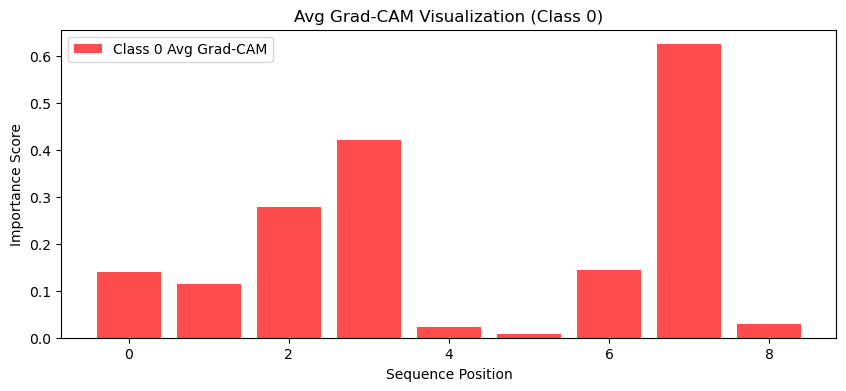

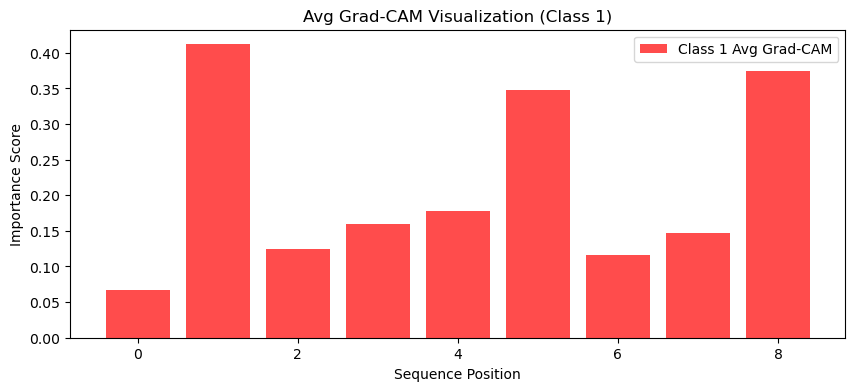

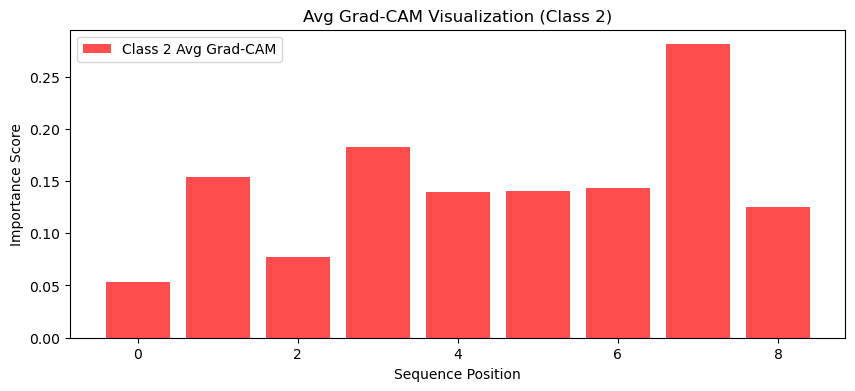

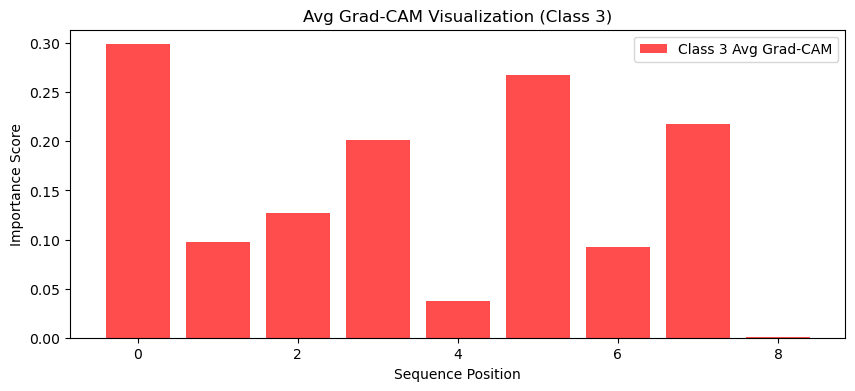

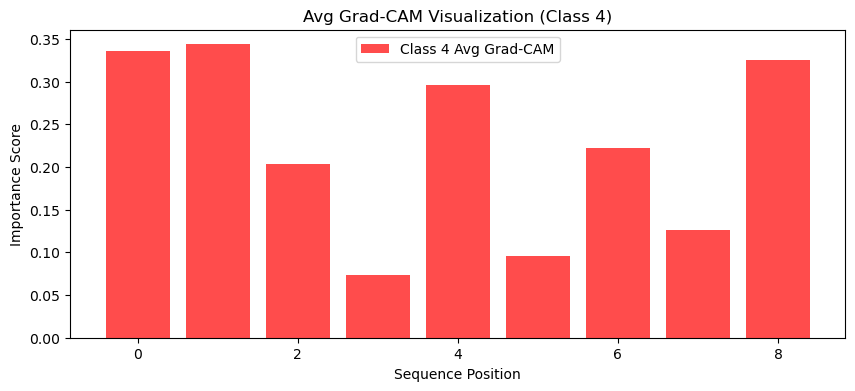

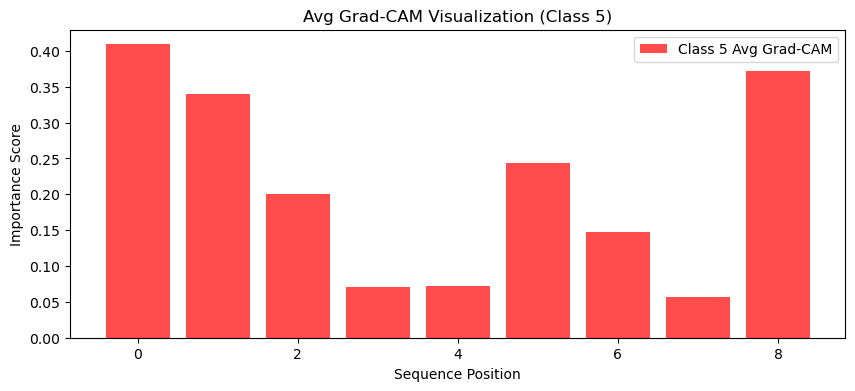

In [27]:
gradcam = GradCAM1D(model, model.conv_final)
avg_feature_maps = compute_classwise_gradcam(model, train_loader, gradcam, device)
plot_avg_gradcam(avg_feature_maps)

"Perturbation-based Sensitivity Analysis" (PSA) 분석

Experiment 2/2: 100%|████████████████████████████████████████████████████████| 3796/3796 [02:04<00:00, 30.51it/s]


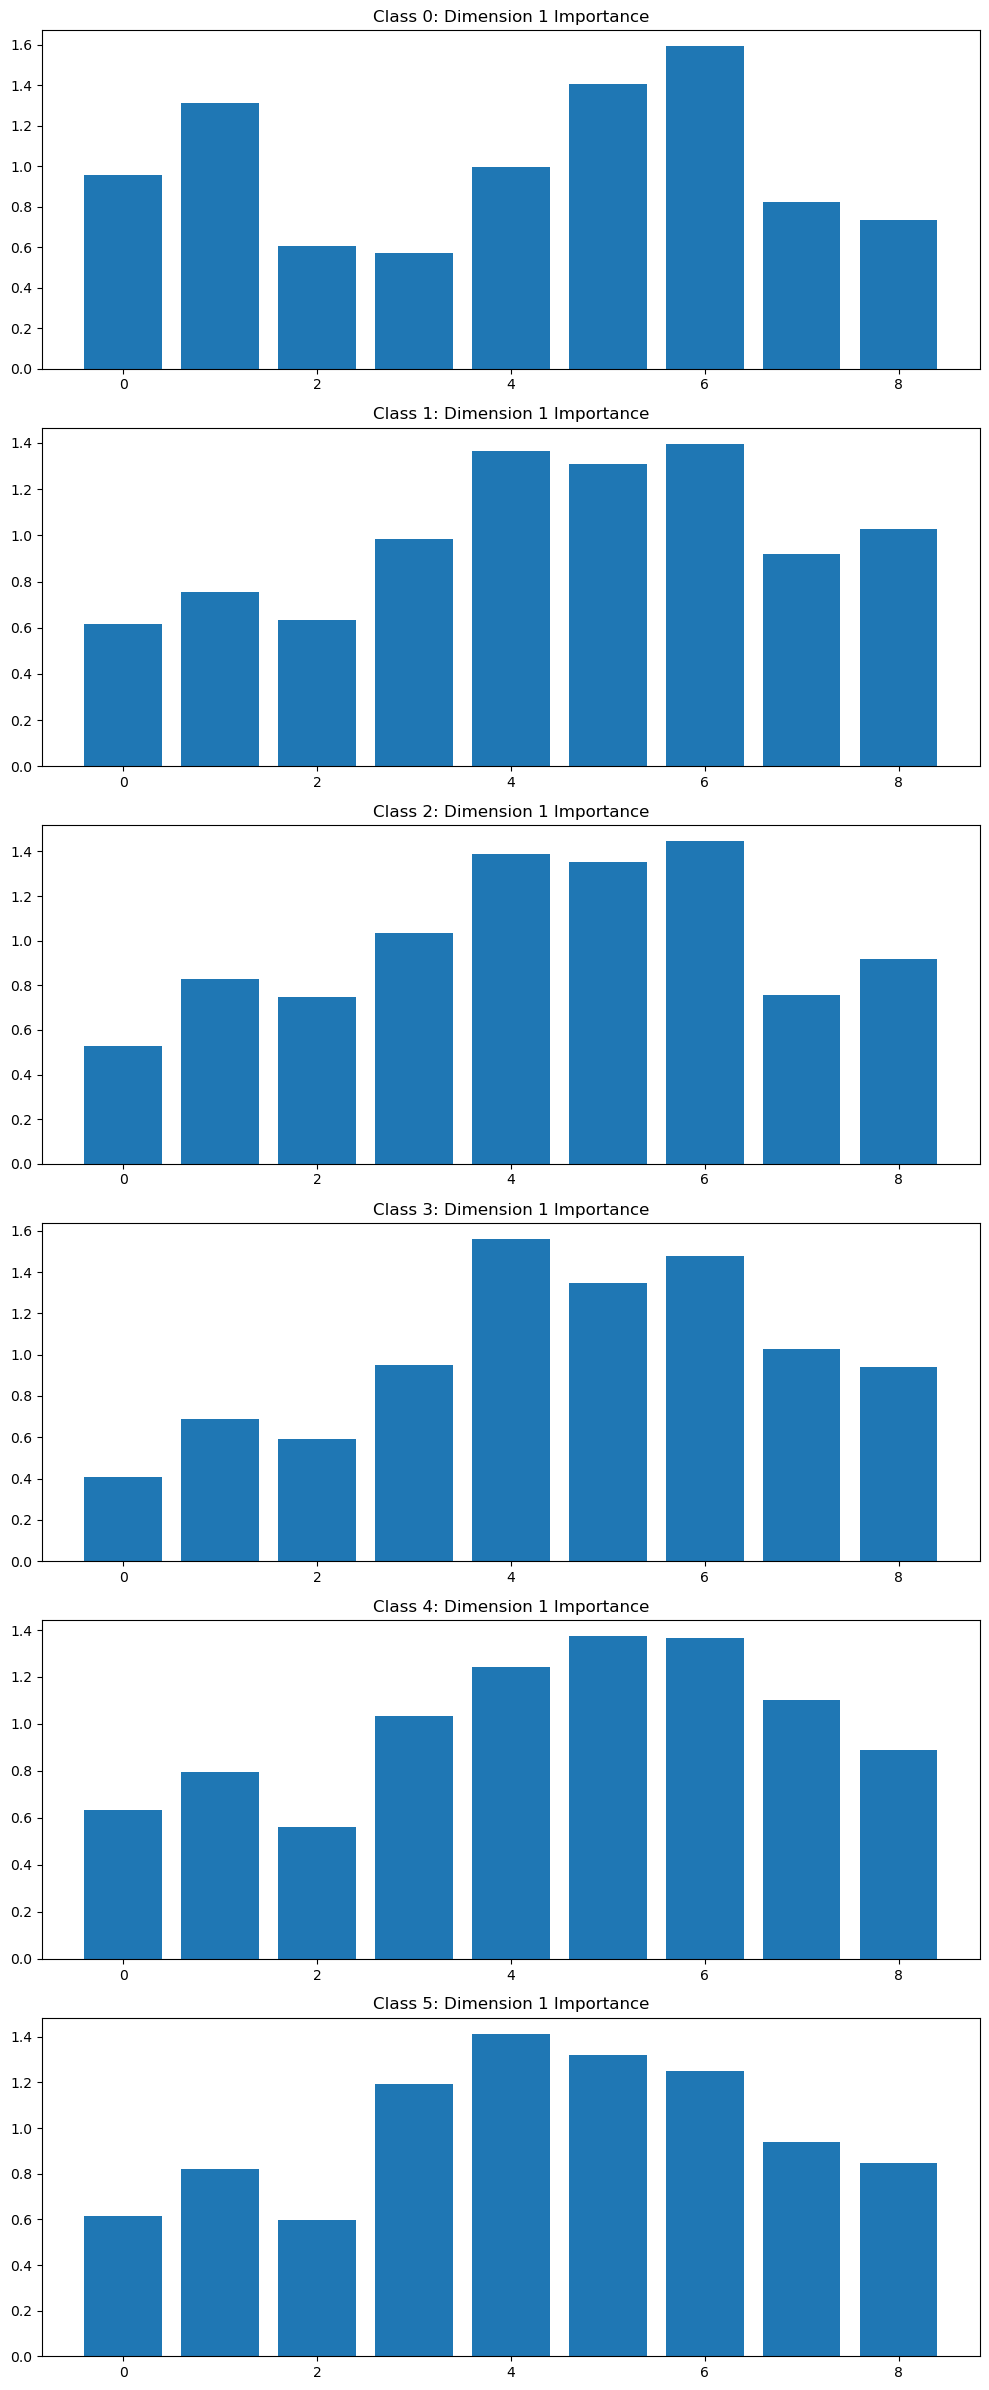

In [35]:
# 교란 분석 실행
_, dim1_importance, _ = evaluate_perturbation(
    model, train_loader, num_classes=6, noise_level=1.0, num_repeats=2, dim1=2
)

# 시각화 실행
plot_band_importance_only(dim1_importance)

In [10]:
# ✅ 메모리 정리
del model,train_dataset, val_dataset, train_loader, val_loader
torch.cuda.empty_cache()

## Using Bands, Space

In [37]:
bands = 9
num_epochs = 30
patch_size = 5
time_idx = 5 #5월 중순
checkpoints_dir = "./checkpoints/using_bands_space"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소

In [7]:
transform = transforms.Compose([base_transform(bands, patch_size), transforms.Lambda(lambda x: x[:,time_idx])])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
model = ResNetClassifier(in_channels=9).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# 🔹 Optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 🔹 Learning Rate Scheduler (StepLR: 10 epochs마다 lr 0.1배 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Epoch 1/30 - Validation: 100%|████████████████████████████████████████████████| 936/936 [00:09<00:00, 96.99it/s]



Epoch [1/30], Train Loss: 0.7798, Train Accuracy: 68.66%, Val Loss: 0.8267, Val Accuracy: 66.50%



Epoch 2/30 - Validation: 100%|████████████████████████████████████████████████| 936/936 [00:09<00:00, 97.31it/s]



Epoch [2/30], Train Loss: 0.6535, Train Accuracy: 74.32%, Val Loss: 1.0315, Val Accuracy: 60.24%



Epoch 3/30 - Validation: 100%|████████████████████████████████████████████████| 936/936 [00:09<00:00, 96.17it/s]



Epoch [3/30], Train Loss: 0.6000, Train Accuracy: 76.30%, Val Loss: 0.7637, Val Accuracy: 69.05%



Epoch 4/30 - Validation: 100%|████████████████████████████████████████████████| 936/936 [00:09<00:00, 99.03it/s]



Epoch [4/30], Train Loss: 0.5644, Train Accuracy: 77.70%, Val Loss: 0.7343, Val Accuracy: 70.25%



Epoch 5/30 - Validation: 100%|████████████████████████████████████████████████| 936/936 [00:09<00:00, 97.13it/s]



Epoch [5/30], Train Loss: 0.5383, Train Accuracy: 78.79%, Val Loss: 0.8863, Val Accuracy: 65.85%



Epoch 6/30 - Validation: 100%|████████████████████████████████████████████████| 936/936 [00:09<00:00, 98.77it/s]



Epoch [6/30], Train Loss: 0.5175, Train Accuracy: 79.60%, Val Loss: 0.8258, Val Accuracy: 66.18%



Epoch 7/30 - Validation: 100%|████████████████████████████████████████████████| 936/936 [00:09<00:00, 97.16it/s]



Epoch [7/30], Train Loss: 0.4998, Train Accuracy: 80.27%, Val Loss: 0.9991, Val Accuracy: 62.26%



Epoch 8/30 - Validation: 100%|████████████████████████████████████████████████| 936/936 [00:09<00:00, 97.67it/s]



Epoch [8/30], Train Loss: 0.4863, Train Accuracy: 80.75%, Val Loss: 1.0911, Val Accuracy: 61.67%



Epoch 9/30 - Validation: 100%|████████████████████████████████████████████████| 936/936 [00:09<00:00, 99.99it/s]



Epoch [9/30], Train Loss: 0.4719, Train Accuracy: 81.33%, Val Loss: 0.9546, Val Accuracy: 66.11%



Epoch 10/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 99.77it/s]



Epoch [10/30], Train Loss: 0.4584, Train Accuracy: 81.88%, Val Loss: 1.1230, Val Accuracy: 60.96%



Epoch 11/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 98.98it/s]



Epoch [11/30], Train Loss: 0.4000, Train Accuracy: 84.13%, Val Loss: 0.7233, Val Accuracy: 72.53%



Epoch 12/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 99.66it/s]



Epoch [12/30], Train Loss: 0.3864, Train Accuracy: 84.68%, Val Loss: 0.7231, Val Accuracy: 72.51%



Epoch 13/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 99.31it/s]



Epoch [13/30], Train Loss: 0.3793, Train Accuracy: 84.92%, Val Loss: 0.7260, Val Accuracy: 72.87%



Epoch 14/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 99.15it/s]



Epoch [14/30], Train Loss: 0.3730, Train Accuracy: 85.15%, Val Loss: 0.7510, Val Accuracy: 72.44%



Epoch 15/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 98.02it/s]



Epoch [15/30], Train Loss: 0.3694, Train Accuracy: 85.31%, Val Loss: 0.7393, Val Accuracy: 72.95%



Epoch 16/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 99.35it/s]



Epoch [16/30], Train Loss: 0.3648, Train Accuracy: 85.55%, Val Loss: 0.7309, Val Accuracy: 73.17%



Epoch 17/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 99.09it/s]



Epoch [17/30], Train Loss: 0.3603, Train Accuracy: 85.76%, Val Loss: 0.7586, Val Accuracy: 72.46%



Epoch 18/30 - Validation: 100%|██████████████████████████████████████████████| 936/936 [00:09<00:00, 100.00it/s]



Epoch [18/30], Train Loss: 0.3546, Train Accuracy: 85.95%, Val Loss: 0.7681, Val Accuracy: 72.64%



Epoch 19/30 - Validation: 100%|██████████████████████████████████████████████| 936/936 [00:09<00:00, 100.30it/s]



Epoch [19/30], Train Loss: 0.3517, Train Accuracy: 86.09%, Val Loss: 0.7482, Val Accuracy: 72.94%



Epoch 20/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 98.82it/s]



Epoch [20/30], Train Loss: 0.3491, Train Accuracy: 86.19%, Val Loss: 0.7460, Val Accuracy: 72.85%



Epoch 21/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 99.56it/s]



Epoch [21/30], Train Loss: 0.3394, Train Accuracy: 86.64%, Val Loss: 0.7611, Val Accuracy: 72.72%



Epoch 22/30 - Validation: 100%|██████████████████████████████████████████████| 936/936 [00:09<00:00, 100.47it/s]



Epoch [22/30], Train Loss: 0.3373, Train Accuracy: 86.66%, Val Loss: 0.7364, Val Accuracy: 73.40%



Epoch 23/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 97.75it/s]



Epoch [23/30], Train Loss: 0.3362, Train Accuracy: 86.75%, Val Loss: 0.7499, Val Accuracy: 73.00%



Epoch 24/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:10<00:00, 93.03it/s]



Epoch [24/30], Train Loss: 0.3357, Train Accuracy: 86.64%, Val Loss: 0.7518, Val Accuracy: 73.12%



Epoch 25/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 93.79it/s]



Epoch [25/30], Train Loss: 0.3359, Train Accuracy: 86.66%, Val Loss: 0.7483, Val Accuracy: 73.14%



Epoch 26/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:10<00:00, 90.85it/s]



Epoch [26/30], Train Loss: 0.3362, Train Accuracy: 86.75%, Val Loss: 0.7598, Val Accuracy: 72.84%



Epoch 27/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 99.36it/s]



Epoch [27/30], Train Loss: 0.3348, Train Accuracy: 86.69%, Val Loss: 0.7423, Val Accuracy: 73.36%



Epoch 28/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 99.99it/s]



Epoch [28/30], Train Loss: 0.3345, Train Accuracy: 86.73%, Val Loss: 0.7486, Val Accuracy: 73.25%



Epoch 29/30 - Validation: 100%|███████████████████████████████████████████████| 936/936 [00:09<00:00, 99.24it/s]



Epoch [29/30], Train Loss: 0.3328, Train Accuracy: 86.85%, Val Loss: 0.7503, Val Accuracy: 73.26%



Epoch 30/30 - Validation: 100%|██████████████████████████████████████████████| 936/936 [00:09<00:00, 101.75it/s]



Epoch [30/30], Train Loss: 0.3330, Train Accuracy: 86.80%, Val Loss: 0.7613, Val Accuracy: 73.05%


train data


Evaluation Progress: 100%|██████████████████████████████████████████████████| 3773/3773 [00:40<00:00, 92.83it/s]


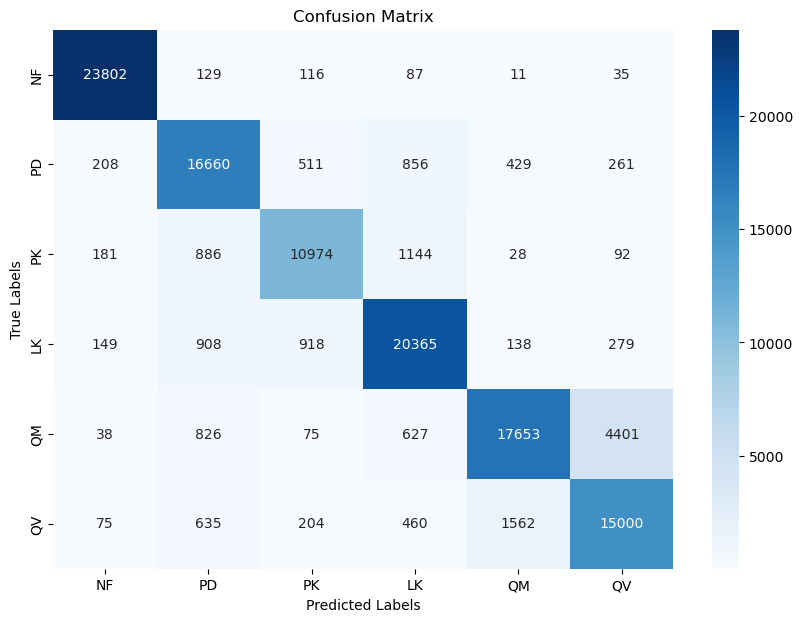

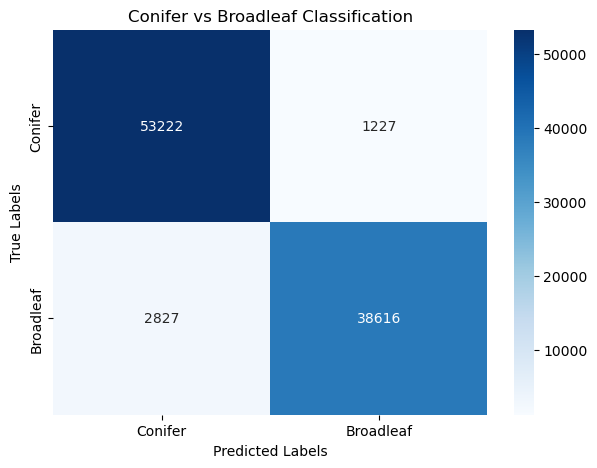

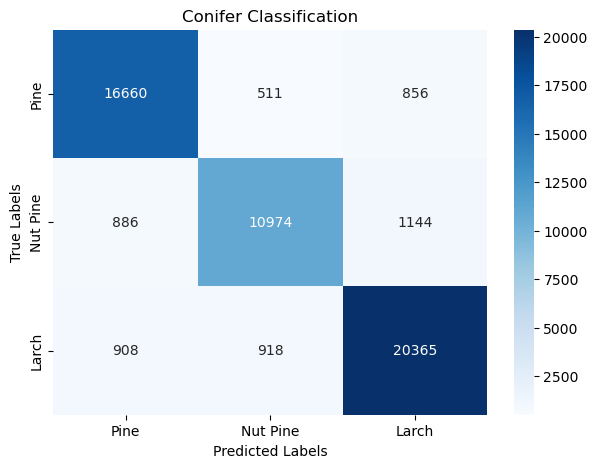

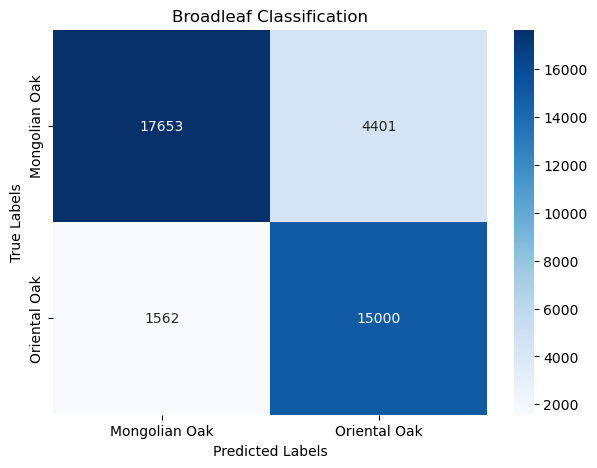


validation data


Evaluation Progress: 100%|████████████████████████████████████████████████████| 936/936 [00:09<00:00, 94.48it/s]


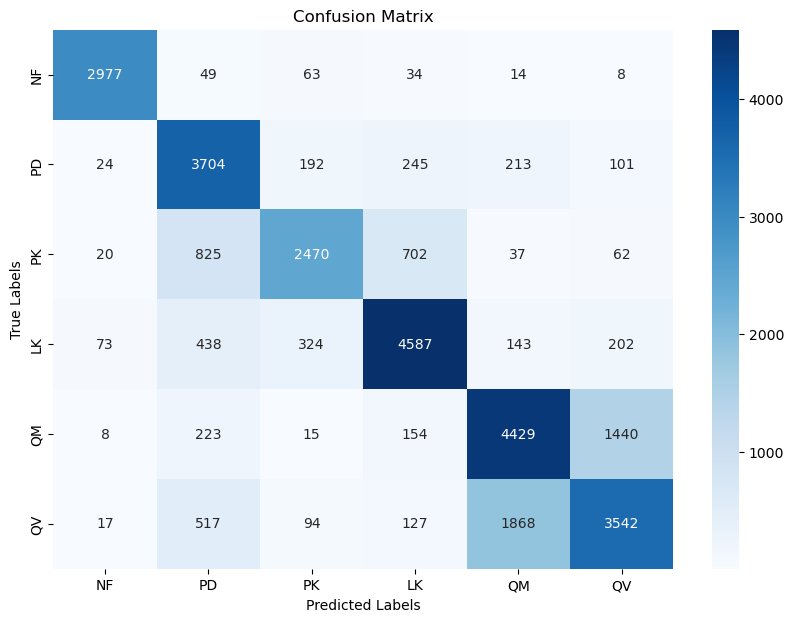

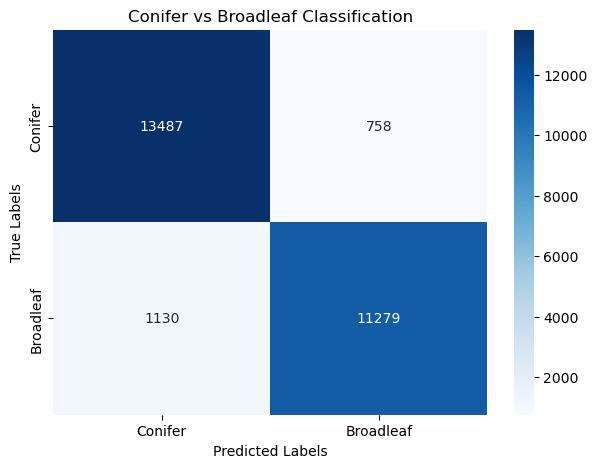

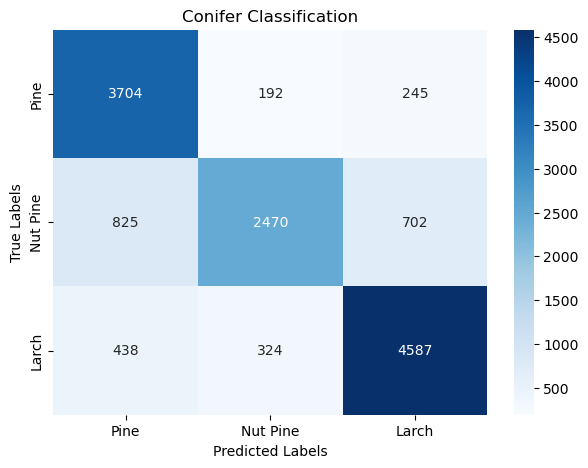

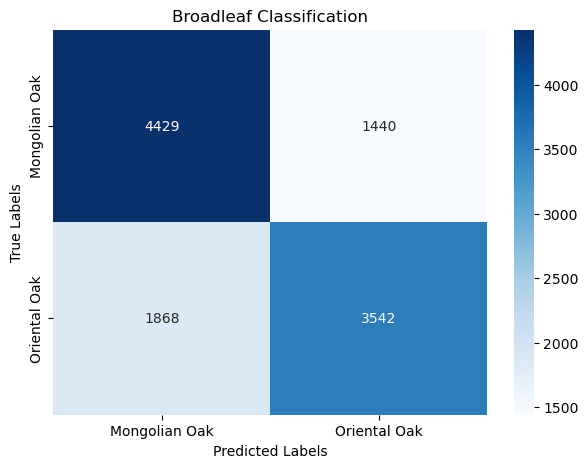

,precision,recall,f1-score,support,Category
NF,0.954473,0.946582,0.950511,3145.000000,Overall
PD,0.643502,0.826970,0.723791,4479.000000,Overall
PK,0.782141,0.600097,0.679131,4116.000000,Overall
LK,0.784237,0.795388,0.789773,5767.000000,Overall
QM,0.660650,0.706492,0.682803,6269.000000,Overall
QV,0.661438,0.574534,0.614931,6165.000000,Overall
accuracy,0.725059,0.725059,0.725059,0.725059,Overall
macro avg,0.747740,0.741677,0.740156,29941.000000,Overall
weighted avg,0.729616,0.725059,0.723178,29941.000000,Overall
Conifer,0.922693,0.946788,0.934585,14245.000000,Conifer vs Broadleaf


In [14]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"resnet_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [9]:
# ✅ 메모리 정리
del model,train_dataset, val_dataset, train_loader, val_loader
torch.cuda.empty_cache()

NameError: name 'model' is not defined

## Using Bands, Time

(12,9)

In [11]:
bands = 9
num_epochs = 30
patch_size = 1
checkpoints_dir = "./checkpoints/using_bands_space"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소

In [12]:
def reshape_transform(x):
    x = x.squeeze(-1).squeeze(-1)  # (9, 12, 1, 1) → (9, 12)
    x = x.permute(1, 0)  # (9, 12) → (12, 9)
    return x

transform = transforms.Compose([
    base_transform(bands, patch_size), transforms.Lambda(reshape_transform)
])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
model =  TransformerClassifier(input_dim=9, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=12).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer 설정
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Scheduler 설정 (Cosine Annealing + Warmup)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

Epoch 1/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 163.76it/s]



Epoch [1/30], Train Loss: 0.7918, Train Accuracy: 68.76%, Val Loss: 0.7034, Val Accuracy: 69.94%



Epoch 2/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 158.92it/s]



Epoch [2/30], Train Loss: 0.6019, Train Accuracy: 76.23%, Val Loss: 0.5941, Val Accuracy: 76.98%



Epoch 3/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 163.26it/s]



Epoch [3/30], Train Loss: 0.5489, Train Accuracy: 78.58%, Val Loss: 0.5852, Val Accuracy: 78.02%



Epoch 4/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 165.55it/s]



Epoch [4/30], Train Loss: 0.5021, Train Accuracy: 80.40%, Val Loss: 0.5188, Val Accuracy: 79.13%



Epoch 5/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 164.31it/s]



Epoch [5/30], Train Loss: 0.4660, Train Accuracy: 81.93%, Val Loss: 0.5342, Val Accuracy: 77.51%



Epoch 6/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 163.63it/s]



Epoch [6/30], Train Loss: 0.4425, Train Accuracy: 82.91%, Val Loss: 0.5244, Val Accuracy: 79.15%



Epoch 7/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 163.84it/s]



Epoch [7/30], Train Loss: 0.4232, Train Accuracy: 83.57%, Val Loss: 0.4815, Val Accuracy: 81.35%



Epoch 8/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 166.32it/s]



Epoch [8/30], Train Loss: 0.4203, Train Accuracy: 83.65%, Val Loss: 0.5118, Val Accuracy: 79.58%



Epoch 9/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 158.63it/s]



Epoch [9/30], Train Loss: 0.4221, Train Accuracy: 83.68%, Val Loss: 0.5416, Val Accuracy: 78.08%



Epoch 10/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 163.33it/s]



Epoch [10/30], Train Loss: 0.4014, Train Accuracy: 84.48%, Val Loss: 0.5278, Val Accuracy: 79.07%



Epoch 11/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 166.22it/s]



Epoch [11/30], Train Loss: 0.4012, Train Accuracy: 84.48%, Val Loss: 0.5019, Val Accuracy: 80.37%



Epoch 12/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 165.88it/s]



Epoch [12/30], Train Loss: 0.3893, Train Accuracy: 85.03%, Val Loss: 0.4831, Val Accuracy: 81.38%



Epoch 13/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 167.91it/s]



Epoch [13/30], Train Loss: 0.3839, Train Accuracy: 85.11%, Val Loss: 0.4828, Val Accuracy: 81.34%



Epoch 14/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 157.78it/s]



Epoch [14/30], Train Loss: 0.3724, Train Accuracy: 85.71%, Val Loss: 0.5060, Val Accuracy: 80.93%



Epoch 15/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 163.36it/s]



Epoch [15/30], Train Loss: 0.3642, Train Accuracy: 86.07%, Val Loss: 0.4748, Val Accuracy: 81.43%



Epoch 16/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 164.89it/s]



Epoch [16/30], Train Loss: 0.3556, Train Accuracy: 86.46%, Val Loss: 0.4604, Val Accuracy: 82.24%



Epoch 17/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 166.72it/s]



Epoch [17/30], Train Loss: 0.3510, Train Accuracy: 86.43%, Val Loss: 0.5151, Val Accuracy: 80.28%



Epoch 18/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 165.58it/s]



Epoch [18/30], Train Loss: 0.3441, Train Accuracy: 86.90%, Val Loss: 0.5049, Val Accuracy: 80.45%



Epoch 19/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 162.41it/s]



Epoch [19/30], Train Loss: 0.3385, Train Accuracy: 87.07%, Val Loss: 0.4776, Val Accuracy: 81.78%



Epoch 20/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 164.86it/s]



Epoch [20/30], Train Loss: 0.3315, Train Accuracy: 87.29%, Val Loss: 0.4654, Val Accuracy: 82.76%



Epoch 21/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 163.91it/s]



Epoch [21/30], Train Loss: 0.3275, Train Accuracy: 87.53%, Val Loss: 0.4626, Val Accuracy: 82.34%



Epoch 22/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 163.99it/s]



Epoch [22/30], Train Loss: 0.3176, Train Accuracy: 87.92%, Val Loss: 0.4742, Val Accuracy: 82.79%



Epoch 23/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 165.70it/s]



Epoch [23/30], Train Loss: 0.3161, Train Accuracy: 87.97%, Val Loss: 0.4873, Val Accuracy: 81.83%



Epoch 24/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 165.61it/s]



Epoch [24/30], Train Loss: 0.3098, Train Accuracy: 88.19%, Val Loss: 0.4694, Val Accuracy: 82.58%



Epoch 25/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 164.03it/s]



Epoch [25/30], Train Loss: 0.3070, Train Accuracy: 88.36%, Val Loss: 0.4417, Val Accuracy: 83.55%



Epoch 26/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 164.65it/s]



Epoch [26/30], Train Loss: 0.3005, Train Accuracy: 88.56%, Val Loss: 0.4625, Val Accuracy: 82.73%



Epoch 27/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 165.85it/s]



Epoch [27/30], Train Loss: 0.2978, Train Accuracy: 88.63%, Val Loss: 0.5115, Val Accuracy: 81.16%



Epoch 28/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 164.71it/s]



Epoch [28/30], Train Loss: 0.2924, Train Accuracy: 88.88%, Val Loss: 0.4936, Val Accuracy: 82.24%



Epoch 29/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 164.85it/s]



Epoch [29/30], Train Loss: 0.2897, Train Accuracy: 89.03%, Val Loss: 0.4868, Val Accuracy: 82.20%



Epoch 30/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 164.49it/s]



Epoch [30/30], Train Loss: 0.2873, Train Accuracy: 89.18%, Val Loss: 0.4815, Val Accuracy: 82.48%


train data


Evaluation Progress: 100%|██████████████████████████████████████████████████| 3796/3796 [00:23<00:00, 164.68it/s]


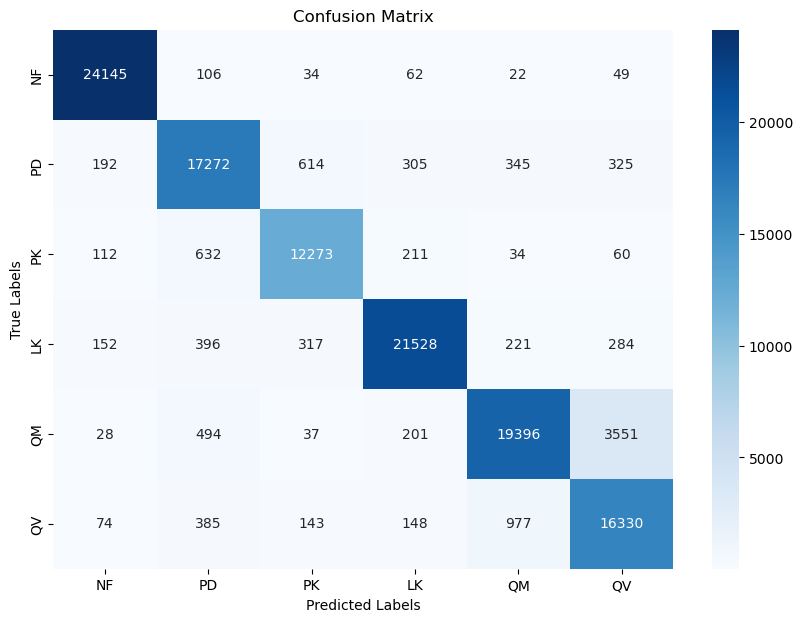

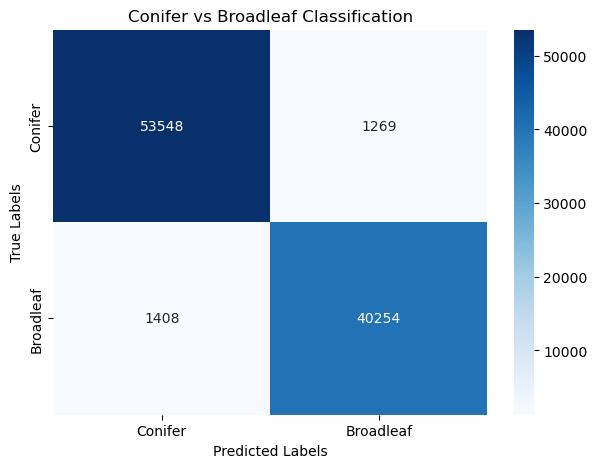

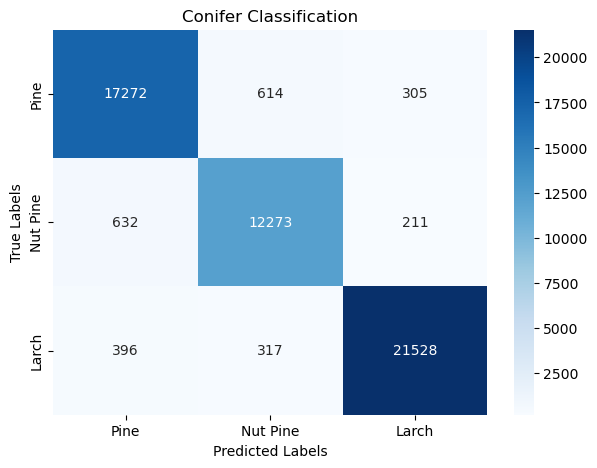

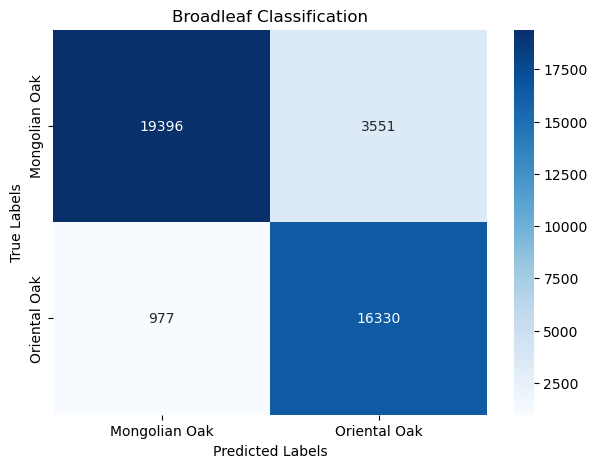


validation data


Evaluation Progress: 100%|████████████████████████████████████████████████████| 940/940 [00:05<00:00, 164.61it/s]


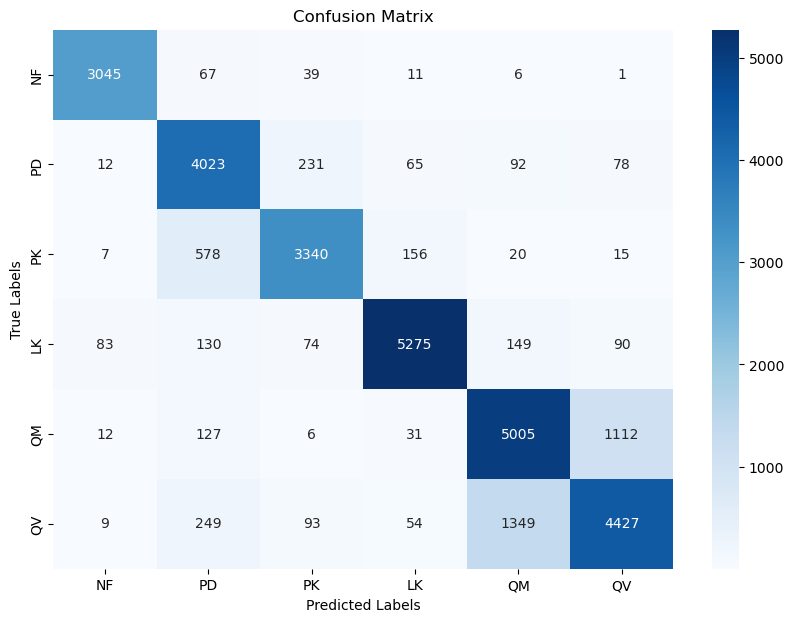

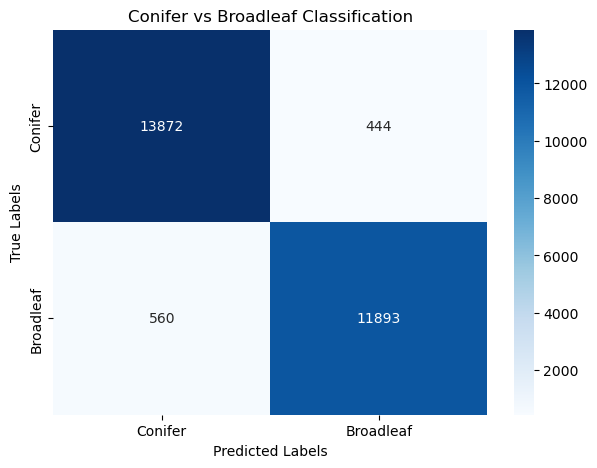

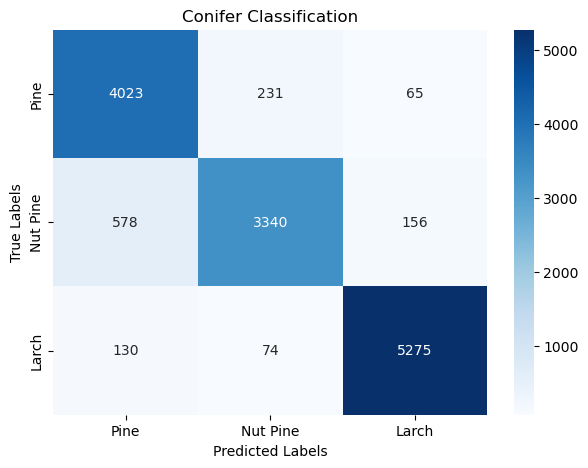

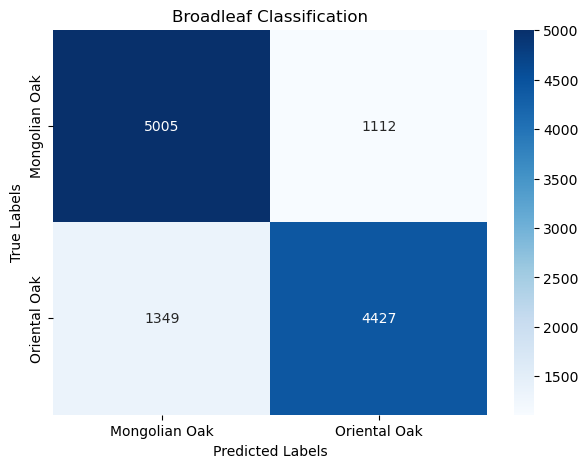

,precision,recall,f1-score,support,Category
NF,0.961174,0.960871,0.961023,3169.000000,Overall
PD,0.777542,0.893801,0.831628,4501.000000,Overall
PK,0.882897,0.811467,0.845677,4116.000000,Overall
LK,0.943312,0.909326,0.926007,5801.000000,Overall
QM,0.755928,0.795328,0.775128,6293.000000,Overall
QV,0.773545,0.716227,0.743784,6181.000000,Overall
accuracy,0.835468,0.835468,0.835468,0.835468,Overall
macro avg,0.849066,0.847837,0.847208,30061.000000,Overall
weighted avg,0.837969,0.835468,0.835515,30061.000000,Overall
Conifer,0.961197,0.968986,0.965076,14316.000000,Conifer vs Broadleaf


In [14]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"transformer_b_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [43]:
model = ResNet1D(in_channels=12, num_classes=6, dropout=0.2).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer 설정
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Scheduler 설정 (Cosine Annealing + Warmup)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

Epoch 1/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:07<00:00, 128.08it/s]



Epoch [1/30], Train Loss: 0.5590, Train Accuracy: 78.00%, Val Loss: 0.5290, Val Accuracy: 78.49%



Epoch 2/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:07<00:00, 129.33it/s]



Epoch [2/30], Train Loss: 0.4111, Train Accuracy: 84.22%, Val Loss: 0.5275, Val Accuracy: 80.14%



Epoch 3/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:07<00:00, 128.69it/s]



Epoch [3/30], Train Loss: 0.3593, Train Accuracy: 86.24%, Val Loss: 0.5468, Val Accuracy: 78.63%



Epoch 4/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:07<00:00, 130.30it/s]



Epoch [4/30], Train Loss: 0.3264, Train Accuracy: 87.59%, Val Loss: 0.5103, Val Accuracy: 80.29%



Epoch 5/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:07<00:00, 128.54it/s]



Epoch [5/30], Train Loss: 0.2981, Train Accuracy: 88.67%, Val Loss: 0.5728, Val Accuracy: 78.11%



Epoch 6/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:07<00:00, 126.22it/s]



Epoch [6/30], Train Loss: 0.2803, Train Accuracy: 89.40%, Val Loss: 0.5009, Val Accuracy: 82.02%



Epoch 7/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:07<00:00, 129.50it/s]



Epoch [7/30], Train Loss: 0.2617, Train Accuracy: 90.20%, Val Loss: 0.5753, Val Accuracy: 80.23%



Epoch 8/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:07<00:00, 128.26it/s]



Epoch [8/30], Train Loss: 0.2471, Train Accuracy: 90.75%, Val Loss: 0.5207, Val Accuracy: 81.89%



Epoch 9/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:07<00:00, 126.25it/s]



Epoch [9/30], Train Loss: 0.2342, Train Accuracy: 91.13%, Val Loss: 0.5858, Val Accuracy: 80.57%



Epoch 10/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 129.22it/s]



Epoch [10/30], Train Loss: 0.2228, Train Accuracy: 91.67%, Val Loss: 0.5830, Val Accuracy: 82.17%



Epoch 11/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 129.93it/s]



Epoch [11/30], Train Loss: 0.2125, Train Accuracy: 92.00%, Val Loss: 0.6227, Val Accuracy: 80.37%



Epoch 12/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 129.53it/s]



Epoch [12/30], Train Loss: 0.2031, Train Accuracy: 92.36%, Val Loss: 0.6181, Val Accuracy: 81.71%



Epoch 13/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 128.47it/s]



Epoch [13/30], Train Loss: 0.1948, Train Accuracy: 92.80%, Val Loss: 0.6273, Val Accuracy: 80.22%



Epoch 14/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 130.34it/s]



Epoch [14/30], Train Loss: 0.1880, Train Accuracy: 93.09%, Val Loss: 0.6000, Val Accuracy: 80.77%



Epoch 15/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 127.11it/s]



Epoch [15/30], Train Loss: 0.1781, Train Accuracy: 93.33%, Val Loss: 0.6651, Val Accuracy: 80.67%



Epoch 16/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 127.45it/s]



Epoch [16/30], Train Loss: 0.1730, Train Accuracy: 93.68%, Val Loss: 0.6191, Val Accuracy: 81.58%



Epoch 17/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 129.27it/s]



Epoch [17/30], Train Loss: 0.1651, Train Accuracy: 93.77%, Val Loss: 0.6115, Val Accuracy: 81.37%



Epoch 18/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 128.63it/s]



Epoch [18/30], Train Loss: 0.1568, Train Accuracy: 94.18%, Val Loss: 0.6677, Val Accuracy: 81.20%



Epoch 19/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 130.85it/s]



Epoch [19/30], Train Loss: 0.1534, Train Accuracy: 94.31%, Val Loss: 0.6538, Val Accuracy: 81.37%



Epoch 20/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 129.69it/s]



Epoch [20/30], Train Loss: 0.1467, Train Accuracy: 94.57%, Val Loss: 0.7119, Val Accuracy: 80.75%



Epoch 21/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 129.60it/s]



Epoch [21/30], Train Loss: 0.1401, Train Accuracy: 94.81%, Val Loss: 0.8539, Val Accuracy: 80.47%



Epoch 22/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 126.53it/s]



Epoch [22/30], Train Loss: 0.1351, Train Accuracy: 95.01%, Val Loss: 0.6923, Val Accuracy: 81.87%



Epoch 23/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 130.15it/s]



Epoch [23/30], Train Loss: 0.1306, Train Accuracy: 95.16%, Val Loss: 0.7413, Val Accuracy: 80.19%



Epoch 24/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 127.72it/s]



Epoch [24/30], Train Loss: 0.1257, Train Accuracy: 95.33%, Val Loss: 0.7333, Val Accuracy: 80.94%



Epoch 25/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 128.20it/s]



Epoch [25/30], Train Loss: 0.1204, Train Accuracy: 95.57%, Val Loss: 0.7631, Val Accuracy: 81.34%



Epoch 26/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 131.21it/s]



Epoch [26/30], Train Loss: 0.1166, Train Accuracy: 95.64%, Val Loss: 0.7290, Val Accuracy: 81.62%



Epoch 27/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 129.67it/s]



Epoch [27/30], Train Loss: 0.1127, Train Accuracy: 95.83%, Val Loss: 0.7143, Val Accuracy: 81.97%



Epoch 28/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 130.18it/s]



Epoch [28/30], Train Loss: 0.1092, Train Accuracy: 95.95%, Val Loss: 0.8635, Val Accuracy: 80.30%



Epoch 29/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 129.65it/s]



Epoch [29/30], Train Loss: 0.1022, Train Accuracy: 96.20%, Val Loss: 0.8121, Val Accuracy: 81.35%



Epoch 30/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 130.53it/s]



Epoch [30/30], Train Loss: 0.0998, Train Accuracy: 96.28%, Val Loss: 0.8363, Val Accuracy: 80.53%


train data


Evaluation Progress: 100%|██████████████████████████████████████████████████| 3796/3796 [00:31<00:00, 120.86it/s]


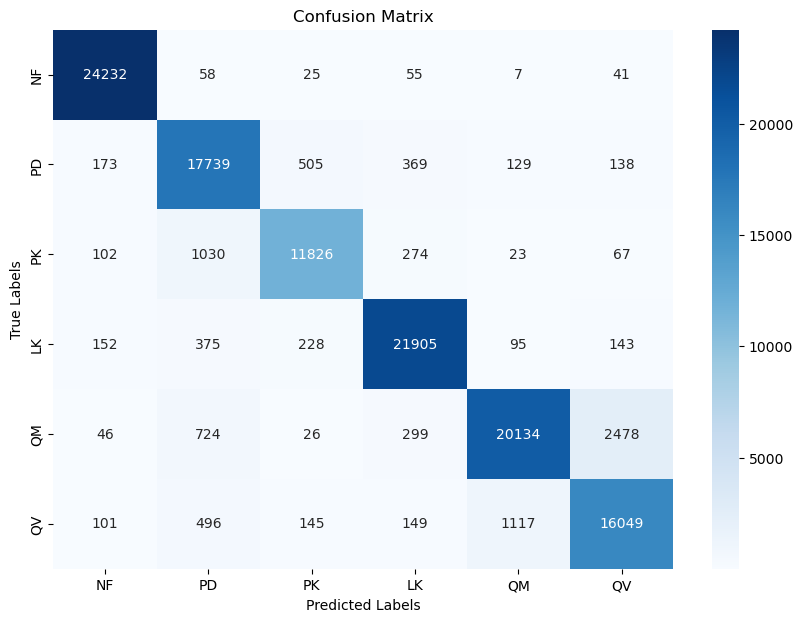

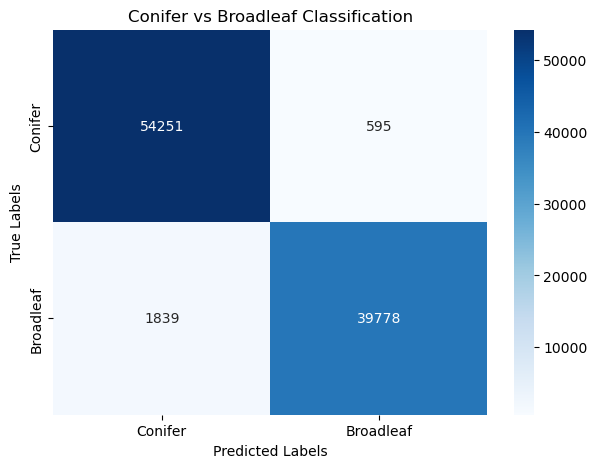

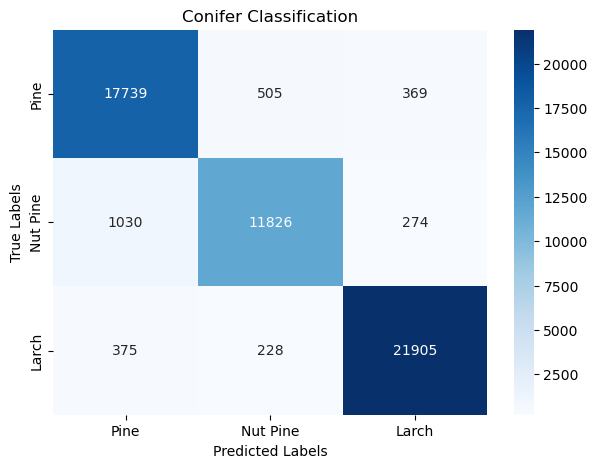

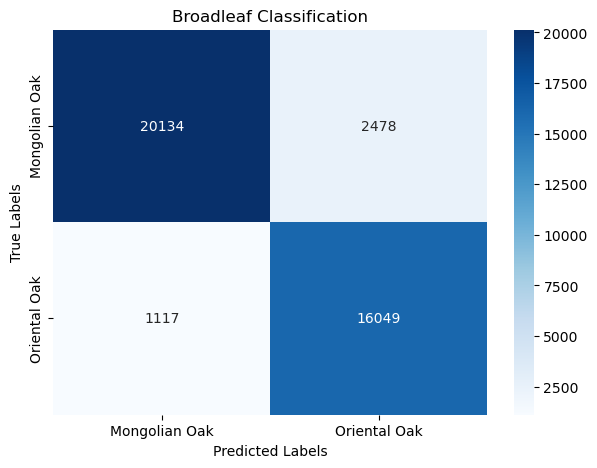


validation data


Evaluation Progress: 100%|████████████████████████████████████████████████████| 940/940 [00:07<00:00, 121.84it/s]


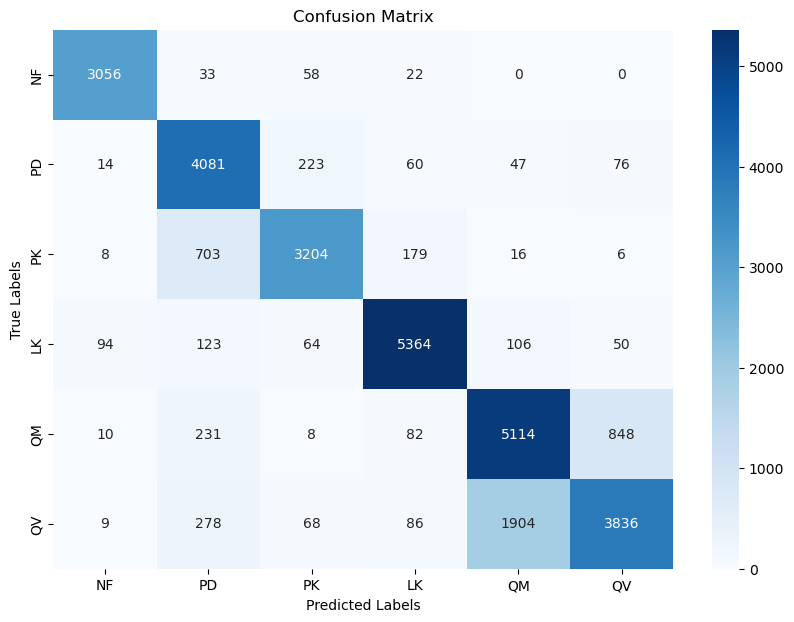

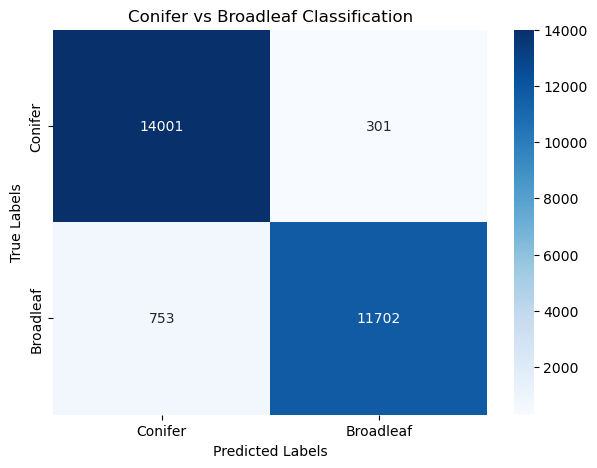

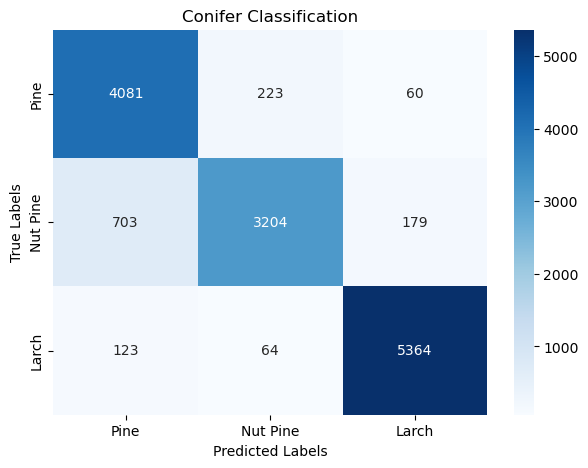

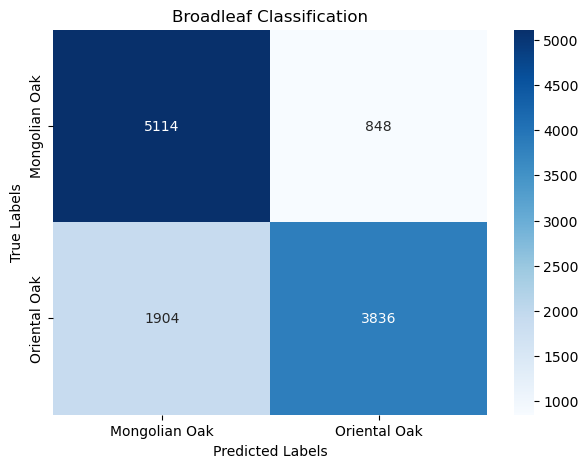

,precision,recall,f1-score,support,Category
NF,0.957694,0.964342,0.961006,3169.000000,Overall
PD,0.748945,0.906687,0.820302,4501.000000,Overall
PK,0.883862,0.778426,0.827800,4116.000000,Overall
LK,0.925945,0.924668,0.925306,5801.000000,Overall
QM,0.711563,0.812649,0.758754,6293.000000,Overall
QV,0.796512,0.620612,0.697645,6181.000000,Overall
accuracy,0.820166,0.820166,0.820166,0.820166,Overall
macro avg,0.837420,0.834564,0.831802,30061.000000,Overall
weighted avg,0.825535,0.820166,0.818320,30061.000000,Overall
Conifer,0.948963,0.978954,0.963725,14302.000000,Conifer vs Broadleaf


In [44]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"resnet1d_b_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

Processing batches: 100%|█████████████████████████████████████████| 940/940 [02:37<00:00,  5.95it/s]


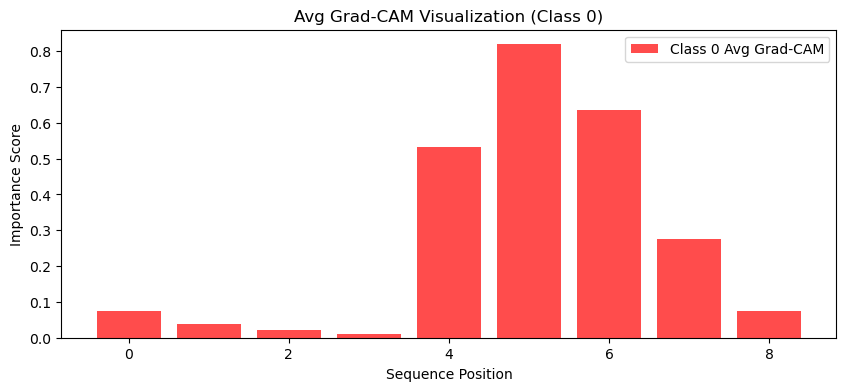

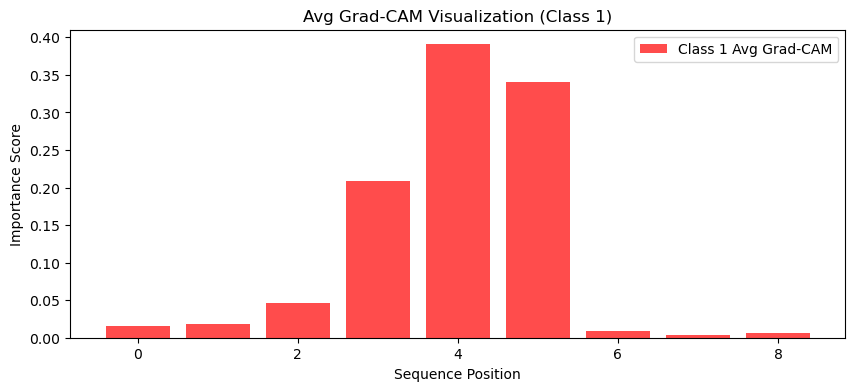

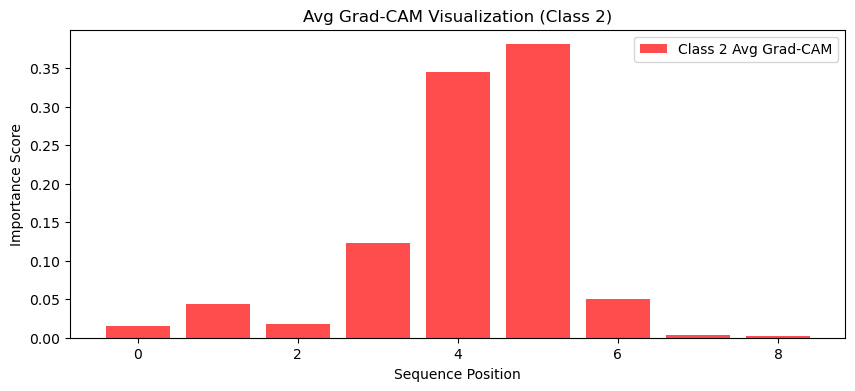

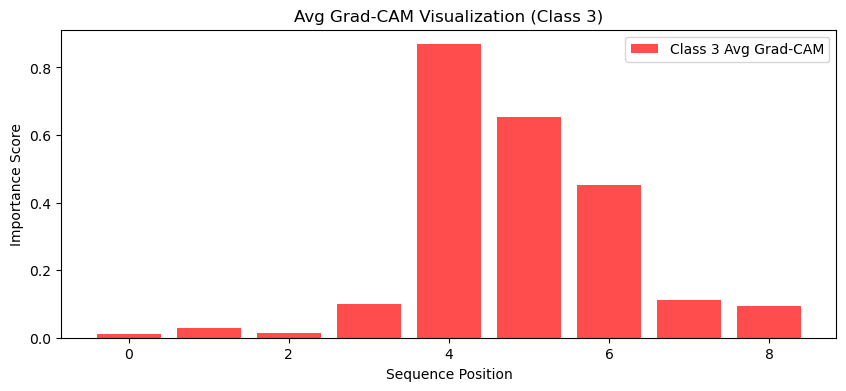

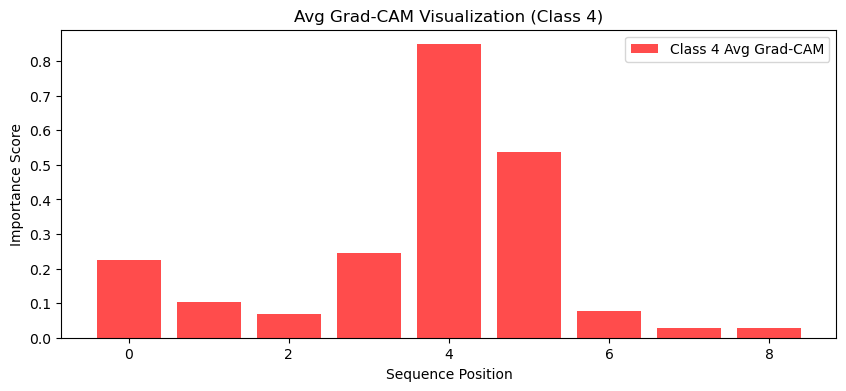

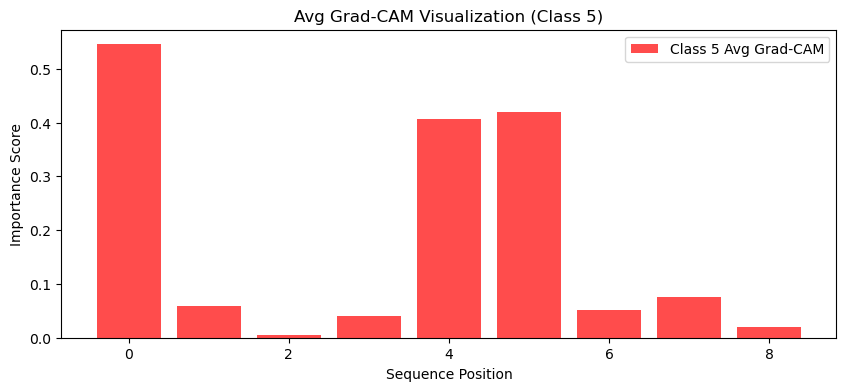

In [45]:
# 사용 예시
gradcam = GradCAM1D(model, model.conv_final)
avg_feature_maps = compute_classwise_gradcam(model, val_loader, gradcam, device)
plot_avg_gradcam(avg_feature_maps)

In [49]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([32, 12, 9])


In [51]:
def evaluate_perturbation(model, dataloader, num_classes=6, noise_level=0.1, num_repeats=1, dim1=1, dim2=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # 데이터 차원 정보 가져오기
    data_shape = next(iter(dataloader))[0].shape
    target_size1, target_size2 = data_shape[dim1], data_shape[dim2] if dim2 is not None else 0

    # 결과 저장을 위한 텐서 초기화
    total_heatmap = torch.zeros((num_classes, target_size1, target_size2), device=device) if dim2 is not None else None
    total_band_importance = torch.zeros((num_classes, target_size1), device=device)
    total_time_importance = torch.zeros((num_classes, target_size2), device=device) if dim2 is not None else None

    with torch.no_grad():
        for repeat in range(num_repeats):
            heatmap = torch.zeros((num_classes, target_size1, target_size2), device=device) if dim2 is not None else None
            band_importance = torch.zeros((num_classes, target_size1), device=device)
            time_importance = torch.zeros((num_classes, target_size2), device=device) if dim2 is not None else None

            for data, labels in tqdm(dataloader, desc=f"Experiment {repeat+1}/{num_repeats}"):
                data, labels = data.to(device), labels.to(device)

                # 원본 예측값 저장
                original_logits = model(data)
                original_preds = original_logits.argmax(dim=1)
                tp_mask = (original_preds == labels)

                if dim2 is not None:  # dim2가 있을 때
                    # 특정 dim1, dim2 조합에 대한 perturbation 수행
                    for i in range(target_size1):
                        for j in range(target_size2):
                            perturbed_data = data.clone()
                            perturbed_data[:, i, j] = add_noise(perturbed_data[:, i, j], noise_level)  # 수정된 부분
                            perturbed_logits = model(perturbed_data)
                            mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)

                            for c in range(num_classes):
                                class_mask = (original_preds == c)
                                valid_mask = tp_mask & class_mask
                                heatmap[c, i, j] += mse_loss[valid_mask].sum()

                # dim1 전체를 교란하여 중요도 측정
                for i in range(target_size1):
                    perturbed_data = data.clone()
                    perturbed_data.select(dim1, i).copy_(add_noise(perturbed_data.select(dim1, i), noise_level))
                    perturbed_logits = model(perturbed_data)
                    mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)

                    for c in range(num_classes):
                        class_mask = (original_preds == c)
                        valid_mask = tp_mask & class_mask
                        band_importance[c, i] += mse_loss[valid_mask].sum()

                # dim2 전체를 교란하여 중요도 측정 (dim2가 있을 때)
                if dim2 is not None:
                    for j in range(target_size2):
                        perturbed_data = data.clone()
                        perturbed_data.select(dim2, j).copy_(add_noise(perturbed_data.select(dim2, j), noise_level))
                        perturbed_logits = model(perturbed_data)
                        mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)

                        for c in range(num_classes):
                            class_mask = (original_preds == c)
                            valid_mask = tp_mask & class_mask
                            time_importance[c, j] += mse_loss[valid_mask].sum()

            if dim2 is not None:
                total_heatmap += heatmap
            total_band_importance += band_importance
            if dim2 is not None:
                total_time_importance += time_importance

    # 평균 내기
    if dim2 is not None:
        total_heatmap /= num_repeats
    total_band_importance /= num_repeats
    if dim2 is not None:
        total_time_importance /= num_repeats

    # 정규화 수행
    if dim2 is not None:
        for c in range(num_classes):
            if total_heatmap[c].sum() > 0:
                total_heatmap[c] /= total_heatmap[c].sum()
                total_heatmap[c] *= (target_size1 * target_size2)

    for c in range(num_classes):
        if total_band_importance[c].sum() > 0:
            total_band_importance[c] /= total_band_importance[c].sum()
            total_band_importance[c] *= target_size1

        if dim2 is not None and total_time_importance[c].sum() > 0:
            total_time_importance[c] /= total_time_importance[c].sum()
            total_time_importance[c] *= target_size2

    return (
        total_heatmap.cpu().numpy() if dim2 is not None else None,
        total_band_importance.cpu().numpy(),
        total_time_importance.cpu().numpy() if dim2 is not None else None
    )


Experiment 3/3: 100%|████████████████████████████████████████████████████████| 3796/3796 [23:00<00:00,  2.75it/s]


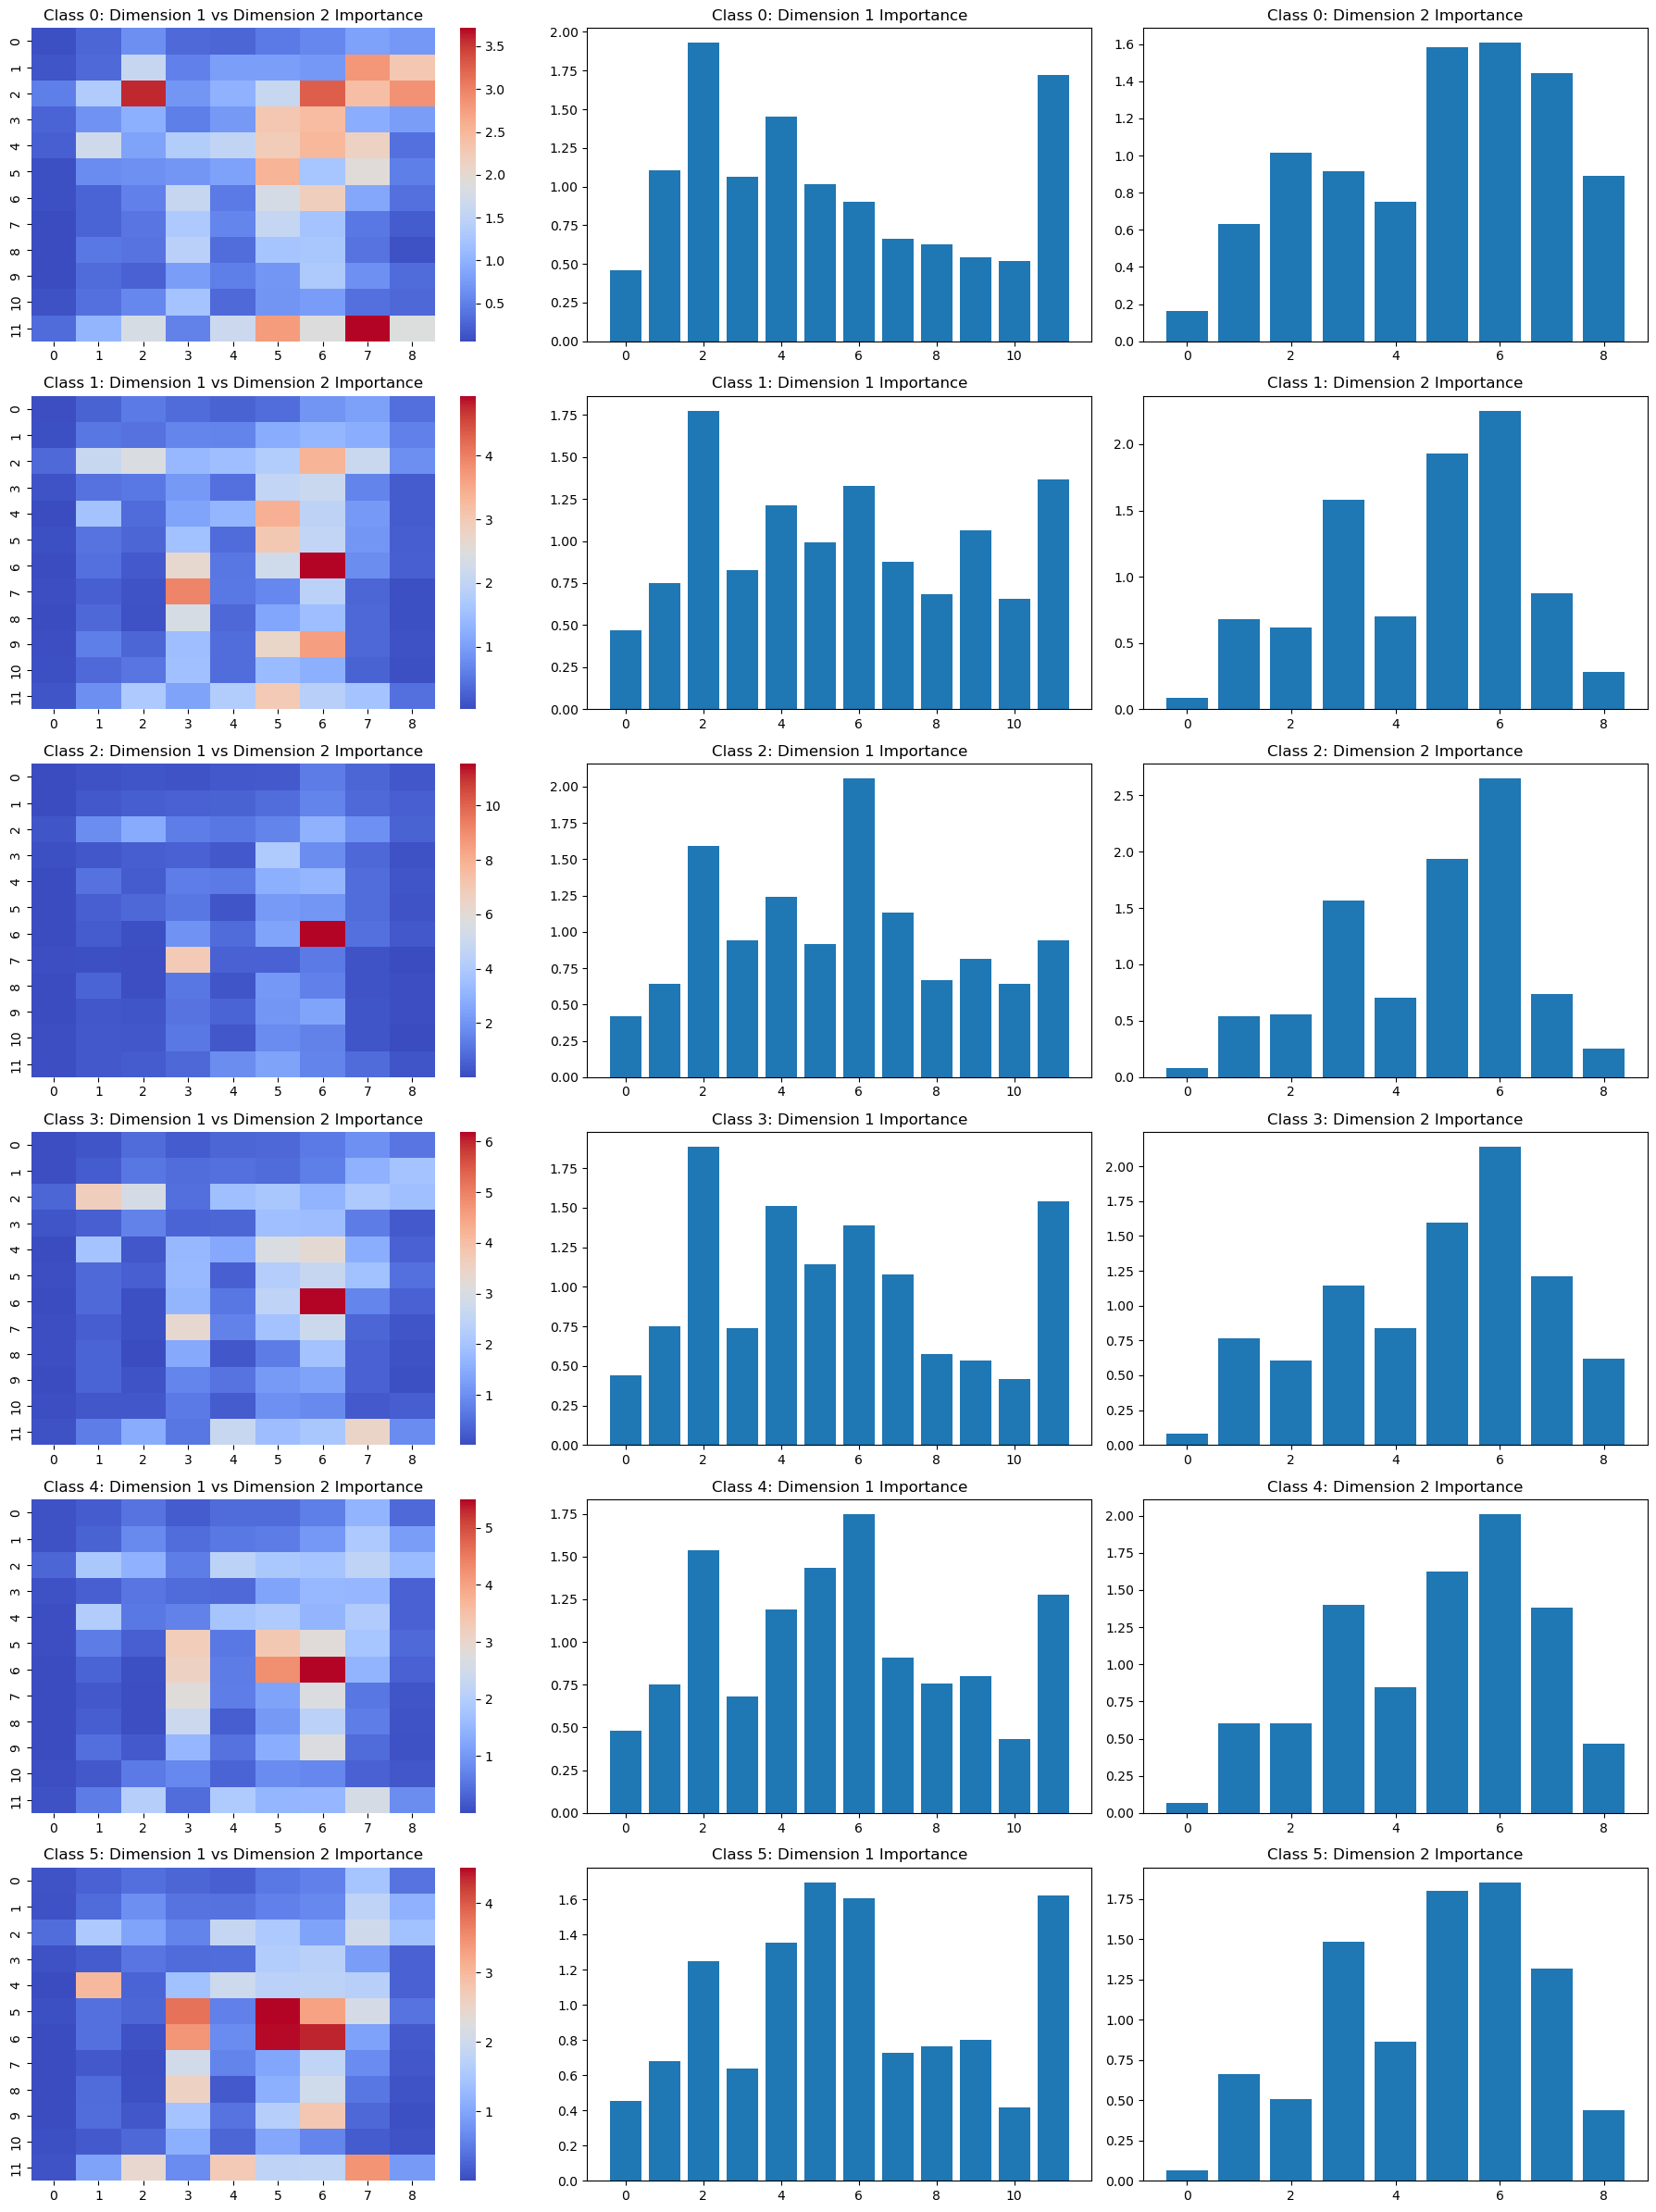

In [52]:
dim1 = 1
dim2 = 2

# 교란 분석 실행
importance_maps, dim1_importance, dim2_importance = evaluate_perturbation(
    model, train_loader, num_classes=6, noise_level=0.1, num_repeats=3, dim1=dim1, dim2=dim2
)

# 시각화 실행
plot_importance_maps(
    importance_maps, dim1_importance, dim2_importance, 
    dim1_label=f"Dimension {dim1}", dim2_label=f"Dimension {dim2}"
)

In [ ]:
perturbation_scores = sdi_importance_analysis(model, train_loader, num_samples=3, perturbation_strength=0.8)

print("전체 차원 중요도:", perturbation_scores["overall"])
print("클래스별 차원 중요도:")
for cls, scores in perturbation_scores["per_class"].items():
    print(f"  클래스 {cls}: {scores}")
plot_importance_scores(perturbation_scores["overall"], perturbation_scores["per_class"])

In [55]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # 모델을 평가 모드로 설정
# model.eval()

# # 클래스별 평균 feature map을 저장할 리스트
# class_feature_maps = {i: [] for i in range(model.fc.out_features)}  # 클래스 수에 맞춰 초기화

# # Grad-CAM 인스턴스 생성 (conv_final 사용)
# gradcam = GradCAM1D(model, model.conv_final)

# # 데이터를 처리하여 각 클래스별 평균 feature map을 계산
# for x, y in tqdm(val_loader, desc="Processing batches", ncols=100):
#     x, y = x.to(device), y.to(device)

#     with torch.no_grad():
#         output = model(x)
#         pred = torch.argmax(output, dim=1)

#     # True Positive 샘플만 처리
#     tp_mask = pred == y
#     tp_indices = torch.where(tp_mask)[0]  # TP 인덱스들

#     for tp_idx in tp_indices:
#         tp_input = x[tp_idx].unsqueeze(0)  # (1, channels, sequence_length)
#         tp_label = y[tp_idx].item()
#         tp_pred = pred[tp_idx].item()

#         if tp_label == tp_pred:  # TP인 경우에만 처리
#             # Grad-CAM 적용
#             heatmap = gradcam.generate_heatmap(tp_input, class_idx=tp_pred)

#             # 해당 클래스의 feature map을 저장
#             class_feature_maps[tp_pred].append(heatmap)

# # 클래스별 평균 feature map 계산
# avg_feature_maps = {}
# for class_idx, feature_maps in class_feature_maps.items():
#     if feature_maps:  # TP 샘플이 존재하는 경우
#         avg_feature_maps[class_idx] = np.mean(np.array(feature_maps), axis=0)
#     else:
#         avg_feature_maps[class_idx] = np.zeros_like(heatmap)  # TP 샘플이 없으면 0으로 채움

# # 시각화: 각 클래스별 평균 feature map
# for class_idx, avg_map in avg_feature_maps.items():
#     sequence_length = len(avg_map)
#     plt.figure(figsize=(10, 4))
#     plt.plot(range(sequence_length), avg_map, label=f"Class {class_idx} Avg Grad-CAM", color='r')
#     plt.fill_between(range(sequence_length), 0, avg_map, color='red', alpha=0.3)
#     plt.xlabel("Sequence Position")
#     plt.ylabel("Importance Score")
#     plt.title(f"Avg Grad-CAM Visualization (Class {class_idx})")
#     plt.legend()
#     plt.show()


In [70]:
# ✅ 메모리 정리
del model,train_dataset, val_dataset, train_loader, val_loader
torch.cuda.empty_cache()

input.shape = (9,12) -> Time 분석 transformer는 time이 토큰인게 좋았다.

In [65]:
bands = 9
num_epochs = 30
patch_size = 1
checkpoints_dir = "./checkpoints/using_bands_space"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소

In [66]:
def reshape_transform(x):
    x = x.squeeze(-1).squeeze(-1)  # (9, 12, 1, 1) → (9, 12)
    return x

transform = transforms.Compose([
    base_transform(bands, patch_size), transforms.Lambda(reshape_transform)
])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [68]:
model =  TransformerClassifier(input_dim=12, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=12).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer 설정
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Scheduler 설정 (Cosine Annealing + Warmup)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

In [69]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler)
#torch.save(best_model_state, os.path.join(checkpoints_dir, f"resnet1d_b_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

Epoch 1/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 166.64it/s]



Epoch [1/30], Train Loss: 0.8956, Train Accuracy: 63.48%, Val Loss: 0.7333, Val Accuracy: 69.29%



Epoch 2/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 168.41it/s]



Epoch [2/30], Train Loss: 0.6518, Train Accuracy: 73.45%, Val Loss: 0.6874, Val Accuracy: 70.59%



Epoch 3/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 166.87it/s]



Epoch [3/30], Train Loss: 0.5755, Train Accuracy: 76.77%, Val Loss: 0.6943, Val Accuracy: 70.91%



Epoch 4/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 170.56it/s]



Epoch [4/30], Train Loss: 0.5293, Train Accuracy: 79.19%, Val Loss: 0.6532, Val Accuracy: 74.68%



Epoch 5/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 168.21it/s]



Epoch [5/30], Train Loss: 0.5212, Train Accuracy: 79.68%, Val Loss: 0.6331, Val Accuracy: 73.35%



Epoch 6/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 168.48it/s]



Epoch [6/30], Train Loss: 0.4896, Train Accuracy: 80.84%, Val Loss: 0.5818, Val Accuracy: 76.49%



Epoch 7/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 169.90it/s]



Epoch [7/30], Train Loss: 0.4641, Train Accuracy: 82.07%, Val Loss: 0.5787, Val Accuracy: 76.29%



Epoch 8/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 168.16it/s]



Epoch [8/30], Train Loss: 0.4440, Train Accuracy: 82.87%, Val Loss: 0.5818, Val Accuracy: 76.66%



Epoch 9/30 - Validation: 100%|████████████████████████████████████████████████| 940/940 [00:05<00:00, 168.01it/s]



Epoch [9/30], Train Loss: 0.4205, Train Accuracy: 83.83%, Val Loss: 0.6340, Val Accuracy: 75.13%



Epoch 10/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 167.35it/s]



Epoch [10/30], Train Loss: 0.4067, Train Accuracy: 84.52%, Val Loss: 0.6018, Val Accuracy: 76.12%



Epoch 11/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 165.68it/s]



Epoch [11/30], Train Loss: 0.3957, Train Accuracy: 85.10%, Val Loss: 0.6224, Val Accuracy: 75.41%



Epoch 12/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 166.08it/s]



Epoch [12/30], Train Loss: 0.3822, Train Accuracy: 85.45%, Val Loss: 0.5963, Val Accuracy: 76.58%



Epoch 13/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 165.25it/s]



Epoch [13/30], Train Loss: 0.3733, Train Accuracy: 85.88%, Val Loss: 0.5470, Val Accuracy: 77.84%



Epoch 14/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 167.87it/s]



Epoch [14/30], Train Loss: 0.3577, Train Accuracy: 86.52%, Val Loss: 0.5669, Val Accuracy: 78.05%



Epoch 15/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 168.20it/s]



Epoch [15/30], Train Loss: 0.3542, Train Accuracy: 86.72%, Val Loss: 0.5760, Val Accuracy: 77.09%



Epoch 16/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 169.17it/s]



Epoch [16/30], Train Loss: 0.3433, Train Accuracy: 87.11%, Val Loss: 0.6392, Val Accuracy: 76.00%



Epoch 17/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 168.86it/s]



Epoch [17/30], Train Loss: 0.3372, Train Accuracy: 87.48%, Val Loss: 0.5739, Val Accuracy: 78.16%



Epoch 18/30 - Training:  83%|███████████████████████████████████████▉        | 3158/3796 [00:34<00:06, 92.18it/s]


KeyboardInterrupt: 

In [21]:
bands = 9
num_epochs = 30
patch_size = 1
checkpoints_dir = "./checkpoints/using_bands_space"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소

In [22]:
def reshape_transform(x):
    x = x.squeeze(-1).squeeze(-1)  # (9, 12, 1, 1) → (9, 12)
    x = x.view(9, 3, 4)  # (9, 12) → (9, 3, 4)
    return x

transform = transforms.Compose([
    base_transform(bands, patch_size), transforms.Lambda(reshape_transform)
])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [23]:
model = ResNetClassifier(in_channels=9).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# 🔹 Optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 🔹 Learning Rate Scheduler (StepLR: 10 epochs마다 lr 0.1배 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Epoch 1/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:08<00:00, 111.23it/s]



Epoch [1/30], Train Loss: 0.4978, Train Accuracy: 81.07%, Val Loss: 0.5677, Val Accuracy: 79.58%



Epoch 2/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:08<00:00, 113.43it/s]



Epoch [2/30], Train Loss: 0.3704, Train Accuracy: 86.13%, Val Loss: 0.5895, Val Accuracy: 79.68%



Epoch 3/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:08<00:00, 113.09it/s]



Epoch [3/30], Train Loss: 0.3105, Train Accuracy: 88.48%, Val Loss: 0.7341, Val Accuracy: 80.49%



Epoch 4/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:08<00:00, 107.39it/s]



Epoch [4/30], Train Loss: 0.2704, Train Accuracy: 89.98%, Val Loss: 0.5514, Val Accuracy: 82.55%



Epoch 5/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:08<00:00, 107.33it/s]



Epoch [5/30], Train Loss: 0.2473, Train Accuracy: 91.00%, Val Loss: 0.8722, Val Accuracy: 78.52%



Epoch 6/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:08<00:00, 105.80it/s]



Epoch [6/30], Train Loss: 0.2199, Train Accuracy: 91.98%, Val Loss: 0.7319, Val Accuracy: 82.47%



Epoch 7/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:08<00:00, 107.57it/s]



Epoch [7/30], Train Loss: 0.2003, Train Accuracy: 92.75%, Val Loss: 0.8694, Val Accuracy: 82.92%



Epoch 8/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:08<00:00, 106.25it/s]



Epoch [8/30], Train Loss: 0.1815, Train Accuracy: 93.45%, Val Loss: 0.7186, Val Accuracy: 79.46%



Epoch 9/30 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:08<00:00, 106.49it/s]



Epoch [9/30], Train Loss: 0.1699, Train Accuracy: 93.83%, Val Loss: 0.6060, Val Accuracy: 82.43%



Epoch 10/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 105.02it/s]



Epoch [10/30], Train Loss: 0.1572, Train Accuracy: 94.30%, Val Loss: 0.6519, Val Accuracy: 81.73%



Epoch 11/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 106.43it/s]



Epoch [11/30], Train Loss: 0.1005, Train Accuracy: 96.39%, Val Loss: 0.7178, Val Accuracy: 83.69%



Epoch 12/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 106.67it/s]



Epoch [12/30], Train Loss: 0.0888, Train Accuracy: 96.81%, Val Loss: 0.8218, Val Accuracy: 83.51%



Epoch 13/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 108.31it/s]



Epoch [13/30], Train Loss: 0.0821, Train Accuracy: 97.03%, Val Loss: 0.8921, Val Accuracy: 83.42%



Epoch 14/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 105.48it/s]



Epoch [14/30], Train Loss: 0.0773, Train Accuracy: 97.23%, Val Loss: 1.0183, Val Accuracy: 82.66%



Epoch 15/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 107.38it/s]



Epoch [15/30], Train Loss: 0.0734, Train Accuracy: 97.38%, Val Loss: 0.9953, Val Accuracy: 83.07%



Epoch 16/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 106.24it/s]



Epoch [16/30], Train Loss: 0.0686, Train Accuracy: 97.55%, Val Loss: 1.0708, Val Accuracy: 83.32%



Epoch 17/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 106.69it/s]



Epoch [17/30], Train Loss: 0.0664, Train Accuracy: 97.61%, Val Loss: 0.9661, Val Accuracy: 82.17%



Epoch 18/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 106.10it/s]



Epoch [18/30], Train Loss: 0.0633, Train Accuracy: 97.73%, Val Loss: 0.9756, Val Accuracy: 82.70%



Epoch 19/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 108.26it/s]



Epoch [19/30], Train Loss: 0.0608, Train Accuracy: 97.81%, Val Loss: 0.9242, Val Accuracy: 83.36%



Epoch 20/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 106.48it/s]



Epoch [20/30], Train Loss: 0.0577, Train Accuracy: 97.90%, Val Loss: 1.2091, Val Accuracy: 82.09%



Epoch 21/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 108.79it/s]



Epoch [21/30], Train Loss: 0.0500, Train Accuracy: 98.17%, Val Loss: 1.1384, Val Accuracy: 82.84%



Epoch 22/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 105.49it/s]



Epoch [22/30], Train Loss: 0.0483, Train Accuracy: 98.29%, Val Loss: 1.0832, Val Accuracy: 83.27%



Epoch 23/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 106.12it/s]



Epoch [23/30], Train Loss: 0.0472, Train Accuracy: 98.32%, Val Loss: 1.0037, Val Accuracy: 83.32%



Epoch 24/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 105.14it/s]



Epoch [24/30], Train Loss: 0.0477, Train Accuracy: 98.29%, Val Loss: 1.2206, Val Accuracy: 82.79%



Epoch 25/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 106.04it/s]



Epoch [25/30], Train Loss: 0.0462, Train Accuracy: 98.35%, Val Loss: 1.1843, Val Accuracy: 83.17%



Epoch 26/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 104.95it/s]



Epoch [26/30], Train Loss: 0.0460, Train Accuracy: 98.35%, Val Loss: 1.3394, Val Accuracy: 82.71%



Epoch 27/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 109.90it/s]



Epoch [27/30], Train Loss: 0.0462, Train Accuracy: 98.35%, Val Loss: 1.1669, Val Accuracy: 83.26%



Epoch 28/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 106.34it/s]



Epoch [28/30], Train Loss: 0.0453, Train Accuracy: 98.36%, Val Loss: 1.3135, Val Accuracy: 82.74%



Epoch 29/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 108.48it/s]



Epoch [29/30], Train Loss: 0.0446, Train Accuracy: 98.39%, Val Loss: 1.1149, Val Accuracy: 83.21%



Epoch 30/30 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:08<00:00, 106.42it/s]



Epoch [30/30], Train Loss: 0.0447, Train Accuracy: 98.40%, Val Loss: 1.2519, Val Accuracy: 82.97%


train data


Evaluation Progress: 100%|█████████████████████████████████████████████████| 3796/3796 [00:37<00:00, 101.09it/s]


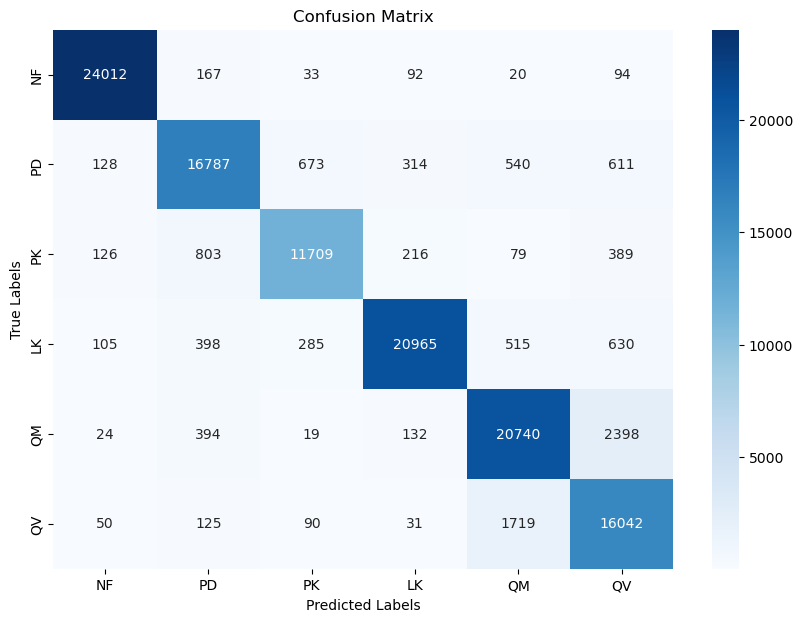

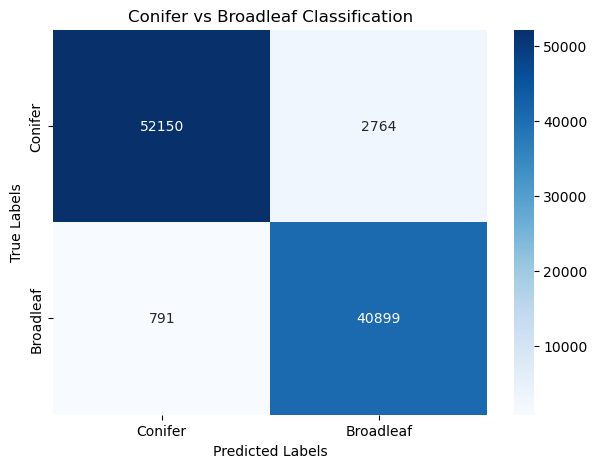

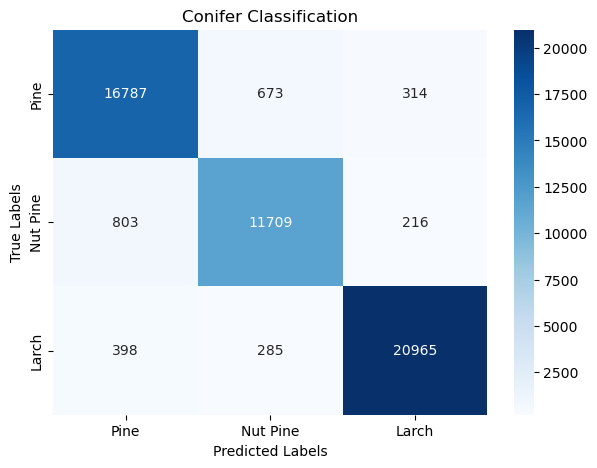

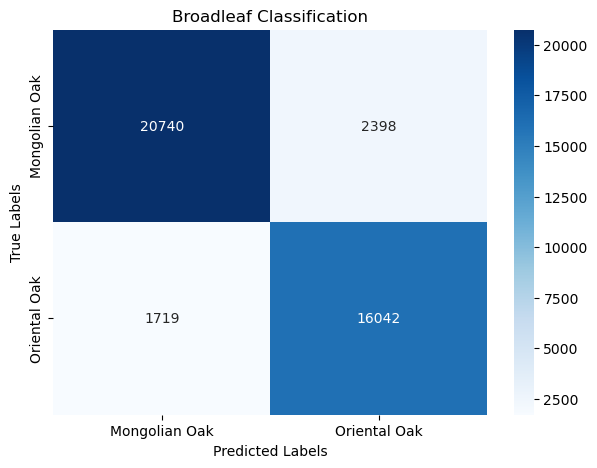


validation data


Evaluation Progress: 100%|███████████████████████████████████████████████████| 940/940 [00:09<00:00, 101.67it/s]


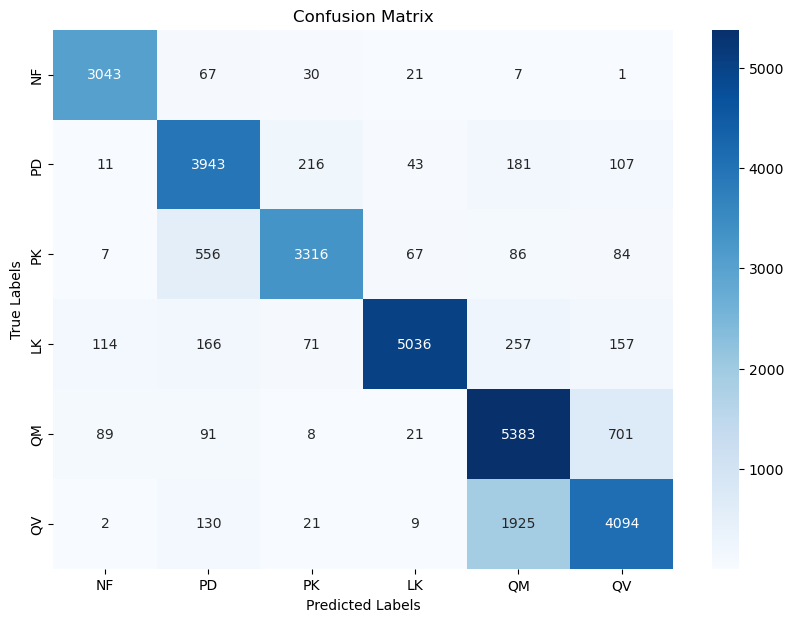

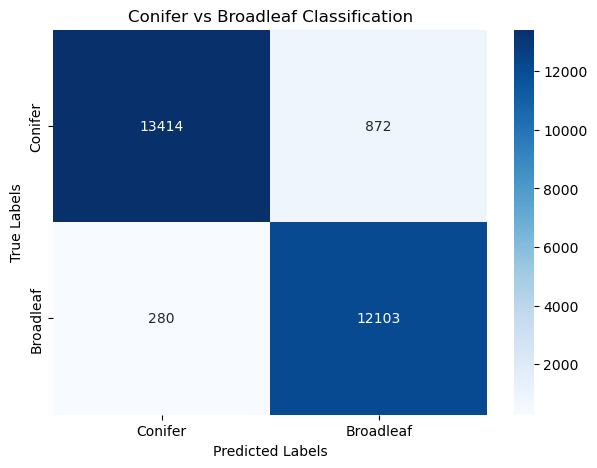

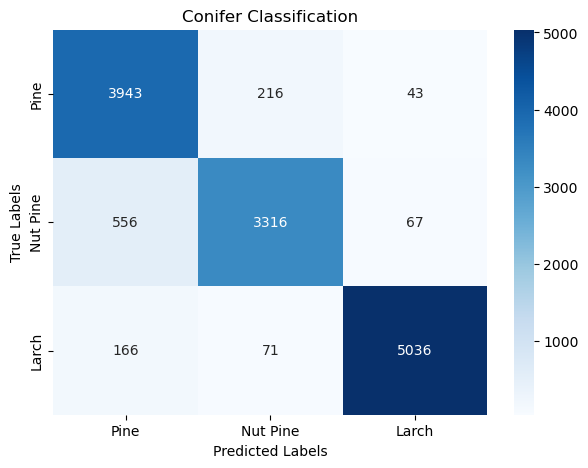

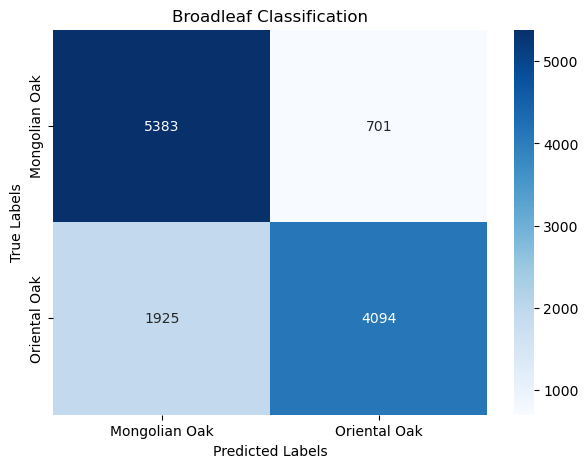

,precision,recall,f1-score,support,Category
NF,0.931721,0.960240,0.945765,3169.000000,Overall
PD,0.796083,0.876028,0.834144,4501.000000,Overall
PK,0.905516,0.805637,0.852661,4116.000000,Overall
LK,0.969021,0.868126,0.915803,5801.000000,Overall
QM,0.686695,0.855395,0.761817,6293.000000,Overall
QV,0.795879,0.662352,0.723002,6181.000000,Overall
accuracy,0.825488,0.825488,0.825488,0.825488,Overall
macro avg,0.847486,0.837963,0.838866,30061.000000,Overall
weighted avg,0.835797,0.825488,0.826211,30061.000000,Overall
Conifer,0.979553,0.938961,0.958828,14286.000000,Conifer vs Broadleaf


In [24]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"resnet_t_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [25]:
# ✅ 메모리 정리
del model,train_dataset, val_dataset, train_loader, val_loader
torch.cuda.empty_cache()

## Using Bands, Time, Space